# Preprocessing and Correlation as Similarity Metric

In [15]:
import os
import anndata as ad
import scipy as sp
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter

In [16]:
"""
The data folder is structured as follows:

data
    |input
        |original
        |pb
        |pb_L
    |output
        |corr
        |gk
        |corr_L
        |graph_sum
        |extra
        |graph
        |plots
        |core_P
"""

data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

original = os.path.join(input, "original")
pb = os.path.join(input, "pb")
pb_L = os.path.join(input, "pb_L")

corr = os.path.join(output, "corr")
gk = os.path.join(output, "gk")
corr_L = gk = os.path.join(output, "corr_L")
graph_sum = os.path.join(output, "graph_sum")
extra = os.path.join(output, "extra")
graph = os.path.join(output, "graph")
core_P = os.path.join(output, "core_P")

In [17]:
# Read Original Data
adt = ad.read_h5ad(os.path.join(original, "adt_pp.h5ad"))
bulkRNA = ad.read_h5ad(os.path.join(original, "bulkRNA_pp.h5ad"))
cytof = ad.read_h5ad (os.path.join(original, "cytof_pp.h5ad"))
facs = ad.read_h5ad(os.path.join(original, "facs_pp.h5ad"))
luminex = ad.read_h5ad(os.path.join(original, "luminex_pp.h5ad"))
scRNA = ad.read_h5ad(os.path.join(original, "scRNA_pp.h5ad"))

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation

In [18]:
# Read Pseudobulks
with open(os.path.join(pb_L, "citeRNA_pseudobulks.pickle"), "rb") as f:
    citeRNA_pseudobulks = pickle.load(f) # Float

with open(os.path.join(pb_L, "adt_pseudobulks.pickle"), "rb") as f:
    adt_pseudobulks = pickle.load(f) # Float

with open(os.path.join(pb_L, "cytof_pseudobulks.pickle"), "rb") as f:
    cytof_pseudobulks = pickle.load(f) # Float

with open(os.path.join(pb_L, "bulkRNA_pseudobulks.pickle"), "rb") as f:
    bulkRNA_pseudobulks = pickle.load(f) # Float

luminex_pseudobulks = pd.read_csv(os.path.join(pb_L, "luminex_pseudobulks.csv"), index_col = 0) # Float
facs_pseudobulks = pd.read_csv(os.path.join(pb_L, "facs_pseudobulks.csv"), index_col = 0)

## Preprocessing
- Extract shared patients and remove noise: 75 
- Get rid of noise networks 
- Map every network to an ID 
- Map every ID to the network's name

In [19]:
# core Patients
shared_patients = set(adt.obs["COMBAT_ID"]).intersection(set(bulkRNA.obs["COMBAT_ID"])).intersection(set(cytof.obs["COMBAT_ID"])).intersection(set(facs.obs["COMBAT_ID"])).intersection(set(luminex.obs["COMBAT_ID"])).intersection(set(scRNA.obs["COMBAT_ID"]))

In [20]:
samples = [sample for sample in luminex_pseudobulks.index if sample.split("-")[0] in shared_patients]
luminex_pseudobulks = luminex_pseudobulks.loc[samples]

samples = [sample for sample in facs_pseudobulks.index if sample.split("-")[0] in shared_patients]
facs_pseudobulks = facs_pseudobulks.loc[samples]

modalities = {"bulkRNA": bulkRNA_pseudobulks, "citeRNA": citeRNA_pseudobulks, "adt": adt_pseudobulks, "cytof": cytof_pseudobulks}

for modality_name in modalities.keys():
    modality = modalities[modality_name]
    networks = {}
    for network_name in modality.keys():
        if not (str(network_name).find("nan") > -1 or str(network_name).find("NaN") > -1 or (str(network_name).find("grey") > -1 and str(network_name).find("grey60") == -1)):
            network = modality[network_name]
            samples = [sample for sample in network.index if sample.split("-")[0] in shared_patients]
            network = network.loc[samples]
            networks[network_name] = network
    
    modalities[modality_name] = networks

bulkRNA_pseudobulks = modalities["bulkRNA"]
citeRNA_pseudobulks = modalities["citeRNA"]
adt_pseudobulks = modalities["adt"]
cytof_pseudobulks = modalities["cytof"]

In [21]:
id_to_name = {}
name_to_id = {}
id_to_pb = {}

num = 0

for modality, dict_of_pbs in modalities.items():
    for pb_name, pb in dict_of_pbs.items():
        id_to_name["G"+ str(num)] = modality + "_" + pb_name
        name_to_id[modality + "_" + pb_name] = "G"+ str(num)
        id_to_pb["G"+ str(num)] = pb
        num+=1

id_to_name["G"+ str(num)] = "luminex"
id_to_pb["G"+ str(num)] = luminex_pseudobulks
name_to_id["luminex"] = "G"+ str(num)

num+=1

id_to_name["G"+ str(num)] = "facs"
id_to_pb["G"+ str(num)] = facs_pseudobulks
name_to_id["facs"] = "G"+ str(num)
    

In [22]:
modalities = {"bulkRNA": bulkRNA, "citeRNA": scRNA, "adt": adt, "cytof": cytof, "luminex": luminex, "facs":facs}
patient_disease_map = {} # map shared patients to diseases
disease_counts = {"COVID_MILD":[], "HV": [], "COVID_SEV":[], "COVID_CONV":[], "COVID_HCW":[], "COVID_CRIT":[], "Sepsis":[]}

for p in shared_patients:
    disease = cytof.obs.Diseases[cytof.obs.COMBAT_ID == p][0]
    disease_counts[disease].append(p)

    for modality_name in modalities.keys():
        modality = modalities[modality_name]
        samples = set(modality.obs.PID[modality.obs.COMBAT_ID == p])
        for sample in samples:
            patient_disease_map[sample] =  disease

for key in disease_counts.keys():
    print(key, len(disease_counts[key]))

COVID_MILD 11
HV 7
COVID_SEV 20
COVID_CONV 7
COVID_HCW 1
COVID_CRIT 13
Sepsis 16


In [23]:
patient_disease_map_reduced = {} # map shared patients to diseases
for k, v in patient_disease_map.items():
    if v == "Sepsis":
        patient_disease_map_reduced[k] = v
    elif v == "HV" or v == "COVID_HCW":
        patient_disease_map_reduced[k] = "Healthy"
    else:
        patient_disease_map_reduced[k] = "Covid"

In [24]:
disease_patient_map = {}
for k,v in patient_disease_map.items():
    if v not in disease_patient_map.keys():
        disease_patient_map[v] = []
    id = k.split("-")[0]
    if id not in disease_patient_map[v]:
        disease_patient_map[v].append(id)

In [25]:
disease_patient_map_reduced = {}
for k,v in patient_disease_map_reduced.items():
    if v not in disease_patient_map_reduced.keys():
        disease_patient_map_reduced[v] = []
    id = k.split("-")[0]
    if id not in disease_patient_map_reduced[v]:
        disease_patient_map_reduced[v].append(id)

## Save Preprocessed Data

In [26]:
with open(os.path.join(core_P, 'patient_disease_map_core.pickle'), 'wb') as f:
    pickle.dump(patient_disease_map, f)

with open(os.path.join(core_P, 'patient_disease_map_core_reduced.pickle'), 'wb') as f:
    pickle.dump(patient_disease_map_reduced, f)

with open(os.path.join(core_P, 'disease_patient_map_core.pickle'), 'wb') as f:
    pickle.dump(disease_patient_map, f)

with open(os.path.join(core_P, 'disease_patient_map_core_reduced.pickle'), 'wb') as f:
    pickle.dump(disease_patient_map_reduced, f)

with open(os.path.join(core_P, 'id_to_name.pickle'), 'wb') as f:
    pickle.dump(id_to_name, f)

with open(os.path.join(core_P, 'name_to_id.pickle'), 'wb') as f:
    pickle.dump(name_to_id, f)

with open(os.path.join(core_P, 'id_to_pb.pickle'), 'wb') as f:
    pickle.dump(id_to_pb, f)

In [27]:
with open(os.path.join(core_P, 'citeRNA_pseudobulks_core.pickle'), 'wb') as f:
    pickle.dump(citeRNA_pseudobulks, f)

with open(os.path.join(core_P, 'bulkRNA_pseudobulks_core.pickle'), 'wb') as f:
    pickle.dump(bulkRNA_pseudobulks, f)

with open(os.path.join(core_P, 'adt_pseudobulks_core.pickle'), 'wb') as f:
    pickle.dump(adt_pseudobulks, f)

with open(os.path.join(core_P, 'cytof_pseudobulks_core.pickle'), 'wb') as f:
    pickle.dump(cytof_pseudobulks, f)

luminex_pseudobulks.to_csv(os.path.join(core_P, "luminex_pseudobulks_core.csv"))
facs_pseudobulks.to_csv(os.path.join(core_P, "facs_pseudobulks_core.csv"))


## Computing Correlation
Computing the following:
- Overall correlation patient x patient: corr_p
- Slicing the overall correlation into inter diseases and intra diseases. Mapping the correlation matrix to disease x disease: citeRNA_disease_clusters_corr

In [28]:
id_to_corr = {}
id_to_num_pateints = {}

### citeRNA

In [29]:
corr_p_citeRNA = {}
for key in citeRNA_pseudobulks.keys():
    pseudo_bulk = citeRNA_pseudobulks[key]
    corr_p_citeRNA[key] = pseudo_bulk.T.corr()
    id = name_to_id["citeRNA" + "_" + key]
    id_to_corr[id] = pseudo_bulk.T.corr()

In [30]:
citeRNA_disease_clusters_corr = {}

for key in corr_p_citeRNA.keys():
    corr_matrix = corr_p_citeRNA[key].rename(index = patient_disease_map, columns = patient_disease_map)
    corr_matrix.sort_index(inplace = True) # Sort the row names
    corr_matrix.sort_index(inplace = True, axis = 1) # Sort the column names
    
    inter_diseases = {}
    intra_diseases = {}

    for i, disease1 in enumerate(corr_matrix.columns.unique()):
        intra_diseases[disease1] = corr_matrix.loc[disease1, disease1]
        for j in range(i):
            disease2 = corr_matrix.columns.unique()[j]
            inter_diseases[disease1 + "_&_" + disease2] = corr_matrix.loc[disease1, disease2]
    
    citeRNA_disease_clusters_corr[key] = {"inter_diseases": inter_diseases, "intra_diseases": intra_diseases, "all" : corr_matrix}

In [31]:
for key in corr_p_citeRNA.keys():
    patients = []
    print(key, " : ", corr_p_citeRNA[key].shape[0]) # Number of samples in each modality
    for c in corr_p_citeRNA[key].columns:
        patients.append(c.split("-")[0])
    id = name_to_id["citeRNA" + "_" + key]
    id_to_num_pateints[id] = len(set(patients))

NK-greenyellow  :  90
NK-tan  :  90
NK-red  :  90
NK-turquoise  :  90
NK-green  :  90
NK-purple  :  90
NK-brown  :  90
NK-blue  :  90
NK-black  :  90
NK-salmon  :  90
NK-lightcyan  :  90
NK-grey60  :  90
NK-lightgreen  :  90
NK-pink  :  90
NK-yellow  :  90
NK-magenta  :  90
NK-cyan  :  90
NK-midnightblue  :  90
NK-lightyellow  :  90
CD8-greenyellow  :  90
CD8-tan  :  90
CD8-red  :  90
CD8-turquoise  :  90
CD8-green  :  90
CD8-purple  :  90
CD8-brown  :  90
CD8-blue  :  90
CD8-black  :  90
CD8-salmon  :  90
CD8-lightcyan  :  90
CD8-grey60  :  90
CD8-lightgreen  :  90
CD8-pink  :  90
CD8-yellow  :  90
CD8-magenta  :  90
CD8-cyan  :  90
CD8-midnightblue  :  90
CD8-lightyellow  :  90
ncMono-greenyellow  :  90
ncMono-tan  :  90
ncMono-red  :  90
ncMono-turquoise  :  90
ncMono-green  :  90
ncMono-purple  :  90
ncMono-brown  :  90
ncMono-blue  :  90
ncMono-black  :  90
ncMono-salmon  :  90
ncMono-lightcyan  :  90
ncMono-grey60  :  90
ncMono-lightgreen  :  90
ncMono-pink  :  90
ncMono-yellow  

### ADT

In [32]:
corr_p_adt = {}
for key in adt_pseudobulks.keys():
    pseudo_bulk = adt_pseudobulks[key]
    corr_p_adt[key] = pseudo_bulk.T.corr()
    id = name_to_id["adt" + "_" + key]
    id_to_corr[id] = pseudo_bulk.T.corr()

In [33]:
adt_disease_clusters_corr = {}

for key in corr_p_adt.keys():
    corr_matrix = corr_p_adt[key].rename(index = patient_disease_map, columns = patient_disease_map)
    corr_matrix.sort_index(inplace = True) # Sort the row names
    corr_matrix.sort_index(inplace = True, axis = 1) # Sort the column names
    
    inter_diseases = {}
    intra_diseases = {}

    for i, disease1 in enumerate(corr_matrix.columns.unique()):
        intra_diseases[disease1] = corr_matrix.loc[disease1, disease1]
        for j in range(i):
            disease2 = corr_matrix.columns.unique()[j]
            inter_diseases[disease1 + "_&_" + disease2] = corr_matrix.loc[disease1, disease2]
    
    adt_disease_clusters_corr[key] = {"inter_diseases": inter_diseases, "intra_diseases": intra_diseases, "all" : corr_matrix}

In [34]:
for key in corr_p_adt.keys():
    patients = []
    print(key, " : ", corr_p_adt[key].shape[0]) # Number of samples in each modality
    for c in corr_p_adt[key].columns:
        patients.append(c.split("-")[0])
    id = name_to_id["adt" + "_" + key]
    id_to_num_pateints[id] = len(set(patients))

NK  :  90
CD8  :  90
ncMono  :  90
cMono  :  90
CD4  :  90
B  :  91
MAIT  :  83
PB  :  91
iNKT  :  46
DN  :  89
DP  :  90
GDT  :  90
HSC  :  89
DC  :  90
PLT  :  82
RET  :  36
Mast  :  28


### CyTOF

In [35]:
corr_p_cytof = {}
for key in cytof_pseudobulks.keys():
    pseudo_bulk = cytof_pseudobulks[key]
    corr_p_cytof[key] = pseudo_bulk.T.corr()
    id = name_to_id["cytof" + "_" + key]
    id_to_corr[id] = pseudo_bulk.T.corr()

In [36]:
cytof_disease_clusters_corr = {}

for key in corr_p_cytof.keys():
    corr_matrix = corr_p_cytof[key].rename(index = patient_disease_map, columns = patient_disease_map)
    corr_matrix.sort_index(inplace = True) # Sort the row names
    corr_matrix.sort_index(inplace = True, axis = 1) # Sort the column names
    
    inter_diseases = {}
    intra_diseases = {}

    for i, disease1 in enumerate(corr_matrix.columns.unique()):
        intra_diseases[disease1] = corr_matrix.loc[disease1, disease1]
        for j in range(i):
            disease2 = corr_matrix.columns.unique()[j]
            inter_diseases[disease1 + "_&_" + disease2] = corr_matrix.loc[disease1, disease2]
    
    cytof_disease_clusters_corr[key] = {"inter_diseases": inter_diseases, "intra_diseases": intra_diseases, "all" : corr_matrix}

In [37]:
corr_p_d_cytof = {}

for key in corr_p_cytof.keys():
    corr_matrix = corr_p_cytof[key].rename(columns = patient_disease_map)
    corr_matrix.sort_index(inplace = True, axis = 1) # Sort the column names
    corr_p_d_cytof[key] = corr_matrix

In [38]:
for key in corr_p_cytof.keys():
    patients = []
    print(key, " : ", corr_p_cytof[key].shape[0]) # Number of samples in each modality
    for c in corr_p_cytof[key].columns:
        patients.append(c.split("-")[0])
    id = name_to_id["cytof" + "_" + key]
    id_to_num_pateints[id] = len(set(patients))

CD8  :  108
B  :  108
cMono  :  108
CD4  :  108
GDT  :  108
DC  :  108
Basophil  :  107
NK  :  108
ncMono  :  108
MAIT  :  108
DN  :  108
PB  :  108


### bulkRNA

In [39]:
corr_p_bulkRNA = {}
for key in bulkRNA_pseudobulks.keys():
    pseudo_bulk = bulkRNA_pseudobulks[key]
    corr_p_bulkRNA[key] = pseudo_bulk.T.corr()
    id = name_to_id["bulkRNA" + "_" + key]
    id_to_corr[id] = pseudo_bulk.T.corr()

In [40]:
bulkRNA_disease_clusters_corr = {}

for key in corr_p_bulkRNA.keys():
    corr_matrix = corr_p_bulkRNA[key].rename(index = patient_disease_map, columns = patient_disease_map)
    corr_matrix.sort_index(inplace = True) # Sort the row names
    corr_matrix.sort_index(inplace = True, axis = 1) # Sort the column names
    
    inter_diseases = {}
    intra_diseases = {}

    for i, disease1 in enumerate(corr_matrix.columns.unique()):
        intra_diseases[disease1] = corr_matrix.loc[disease1, disease1]
        for j in range(i):
            disease2 = corr_matrix.columns.unique()[j]
            inter_diseases[disease1 + "_&_" + disease2] = corr_matrix.loc[disease1, disease2]
    
    bulkRNA_disease_clusters_corr[key] = {"inter_diseases": inter_diseases, "intra_diseases": intra_diseases, "all" : corr_matrix}

In [41]:
for key in corr_p_bulkRNA.keys():
    patients = []
    print(key, " : ", corr_p_bulkRNA[key].shape[0]) # Number of samples in each modality
    for c in corr_p_bulkRNA[key].columns:
        patients.append(c.split("-")[0])
    id = name_to_id["bulkRNA" + "_" + key]
    id_to_num_pateints[id] = len(set(patients))

greenyellow  :  93
green  :  93
magenta  :  93
lightgreen  :  93
black  :  93
turquoise  :  93
lightcyan  :  93
midnightblue  :  93
blue  :  93
grey60  :  93
purple  :  93
cyan  :  93


### Luminex

In [42]:
corr_p_luminex = luminex_pseudobulks.T.corr()
id_to_corr[name_to_id["luminex"]] = pseudo_bulk.T.corr()

In [43]:
corr_d_luminex = corr_p_luminex.rename(index = patient_disease_map, columns = patient_disease_map)
corr_d_luminex.sort_index(inplace = True) # Sort the row names
corr_d_luminex.sort_index(inplace = True, axis = 1) # Sort the column names

In [44]:
corr_p_d_luminex = corr_p_luminex.rename(columns = patient_disease_map) # One axis patients, one axis diseses. Elements are correlations
corr_p_d_luminex.sort_index(inplace = True, axis = 1) # Sort the column names

In [45]:
inter_diseases = {}
intra_diseases = {}

for i, disease1 in enumerate(corr_d_luminex.columns.unique()):
    intra_diseases[disease1] = corr_d_luminex.loc[disease1, disease1]
    for j in range(i):
        disease2 = corr_d_luminex.columns.unique()[j]
        inter_diseases[str(disease1) + "_&_" + disease2] = corr_d_luminex.loc[disease1, disease2]
    
luminex_disease_clusters_corr = {"inter_diseases": inter_diseases, "intra_diseases": intra_diseases, "all" : corr_d_luminex}

In [46]:
print(corr_p_luminex.shape[0]) # Number of samples in each modality
for c in corr_p_luminex.columns:
        patients.append(c.split("-")[0])

id_to_num_pateints[name_to_id["luminex"]] = len(set(patients))


104


### FACS

In [47]:
corr_p_facs = facs_pseudobulks.T.corr()
id_to_corr[name_to_id["facs"]] = pseudo_bulk.T.corr()

In [48]:
corr_d_facs = corr_p_facs.rename(index = patient_disease_map, columns = patient_disease_map)
corr_d_facs.sort_index(inplace = True) # Sort the row names
corr_d_facs.sort_index(inplace = True, axis = 1) # Sort the column names

In [49]:
corr_p_d_facs = corr_p_facs.rename(columns = patient_disease_map) # One axis patients, one axis diseses. Elements are correlations
corr_p_d_facs.sort_index(inplace = True, axis = 1) # Sort the column names

In [50]:
inter_diseases = {}
intra_diseases = {}

for i, disease1 in enumerate(corr_d_facs.columns.unique()):
    intra_diseases[disease1] = corr_d_facs.loc[disease1, disease1]
    for j in range(i):
        disease2 = corr_d_facs.columns.unique()[j]
        inter_diseases[disease1 + "_&_" + disease2] = corr_d_facs.loc[disease1, disease2]
    
facs_disease_clusters_corr = {"inter_diseases": inter_diseases, "intra_diseases": intra_diseases, "all" : corr_d_facs}

In [51]:
print(corr_p_facs.shape[0]) # Number of samples in each modality
for c in corr_p_facs.columns:
        patients.append(c.split("-")[0])

id_to_num_pateints[name_to_id["facs"]] = len(set(patients))

75


## Saving Correlations

In [52]:
with open(os.path.join(corr_L,'citeRNA_disease_clusters_corr.pickle'), 'wb') as f:
    pickle.dump(citeRNA_disease_clusters_corr, f)

with open(os.path.join(corr_L,'corr_p_citeRNA.pickle'), 'wb') as f:
    pickle.dump(corr_p_citeRNA, f)

with open(os.path.join(corr_L,'adt_disease_clusters_corr.pickle'), 'wb') as f:
    pickle.dump(adt_disease_clusters_corr, f)

with open(os.path.join(corr_L,'corr_p_adt.pickle'), 'wb') as f:
    pickle.dump(corr_p_adt, f)

with open(os.path.join(corr_L, 'cytof_disease_clusters_corr.pickle'), 'wb') as f:
    pickle.dump(cytof_disease_clusters_corr, f)

with open(os.path.join(corr_L, 'corr_p_cytof.pickle'), 'wb') as f:
    pickle.dump(corr_p_cytof, f)

with open(os.path.join(corr_L, 'corr_p_d_cytof.pickle'), 'wb') as f:
    pickle.dump(corr_p_d_cytof, f)

with open(os.path.join(corr_L, 'bulkRNA_disease_clusters_corr.pickle'), 'wb') as f:
    pickle.dump(bulkRNA_disease_clusters_corr, f)

with open(os.path.join(corr_L, 'corr_p_bulkRNA.pickle'), 'wb') as f:
    pickle.dump(corr_p_bulkRNA, f)

with open(os.path.join(corr_L, 'corr_p_luminex.pickle'), 'wb') as f:
    pickle.dump(corr_p_luminex, f)

with open(os.path.join(corr_L, 'luminex_disease_clusters_corr.pickle'), 'wb') as f:
    pickle.dump(luminex_disease_clusters_corr, f)

with open(os.path.join(corr_L, 'corr_p_facs.pickle'), 'wb') as f:
    pickle.dump(corr_p_facs, f)

with open(os.path.join(corr_L, 'facs_disease_clusters_corr.pickle'), 'wb') as f:
    pickle.dump(facs_disease_clusters_corr, f)

corr_d_luminex.to_csv(os.path.join(corr_L, "corr_d_luminex.csv"))
corr_d_facs.to_csv(os.path.join(corr_L, "corr_d_facs.csv"))
corr_p_d_facs.to_csv(os.path.join(corr_L, "corr_p_d_facs.csv"))
corr_p_d_luminex.to_csv(os.path.join(corr_L, "corr_p_d_luminex.csv"))

with open(os.path.join(core_P, 'num_patients.pickle'), 'wb') as f:
    pickle.dump(id_to_num_pateints, f)

with open(os.path.join(core_P, 'correlations.pickle'), 'wb') as f:
    pickle.dump(id_to_corr, f)

## Correlation Visualization

### citeRNA

In [53]:
diseases = list(citeRNA_disease_clusters_corr[list(citeRNA_disease_clusters_corr.keys())[0]]["all"].index.unique())
for i in range(1, len(list(citeRNA_disease_clusters_corr.keys()))):
    key = list(citeRNA_disease_clusters_corr.keys())[i]
    diseases = diseases + list((citeRNA_disease_clusters_corr[key]["all"].index.unique()))
diseases = list(set(diseases))

disease_pairs = list(citeRNA_disease_clusters_corr[list(citeRNA_disease_clusters_corr.keys())[0]]["inter_diseases"].keys()) # List of all disease pairs in all pseudobulks. 
                                                                                                                            # It could be the case, that some pairs are not present in all cell-types or modules
for i in range(1, len(list(citeRNA_disease_clusters_corr.keys()))):
    key = list(citeRNA_disease_clusters_corr.keys())[i]
    disease_pairs = disease_pairs + list((citeRNA_disease_clusters_corr[key]["inter_diseases"].keys()))
disease_pairs = list(set(disease_pairs))

In [54]:
non_grey_keys = [key for key in citeRNA_disease_clusters_corr.keys() if key.find("grey") == -1 or key.find("grey60") > 0]

In [55]:
########FIX###############

# All Cell Types and Diseases: Average Correlation between Patients of the Same Disease
module_intra_disease_avg = {m:[0] * len(diseases) for m in citeRNA_disease_clusters_corr.keys() } # For every module and every disease, we compute ome average value, which is the average 
                                                                                                  # of all correlations in the matrix of that disease for that specific module.

for m in citeRNA_disease_clusters_corr.keys():
    for i, disease in enumerate(diseases):
        if (not (m.find("iNKT") > -1 and disease == "Sepsis_conv") and
            not (m.find("RET") > -1 and disease == "COVID_HCW_MILD") and 
            not (m.find("Mast") > -1 and disease == "COVID_HCW_MILD")):
            module_intra_disease_avg[m][i] = citeRNA_disease_clusters_corr[m]["intra_diseases"][disease].mean().mean()
        
df = pd.DataFrame(data = module_intra_disease_avg, index = diseases)

fig, ax = plt.subplots(figsize=(20,10))  
sb.heatmap(df, cmap ='Greys',  robust = True, linewidth=0.4, linecolor = "grey", cbar_kws={"shrink": 0.6}, ax = ax)
plt.title("Average Intra-Disease Correlations Per Module for citeRNA")

plt.ylabel("Diseases")
plt.xlabel("Module")


KeyError: 'COVID_HCW'

Text(0.5, 80.7222222222222, 'Module')

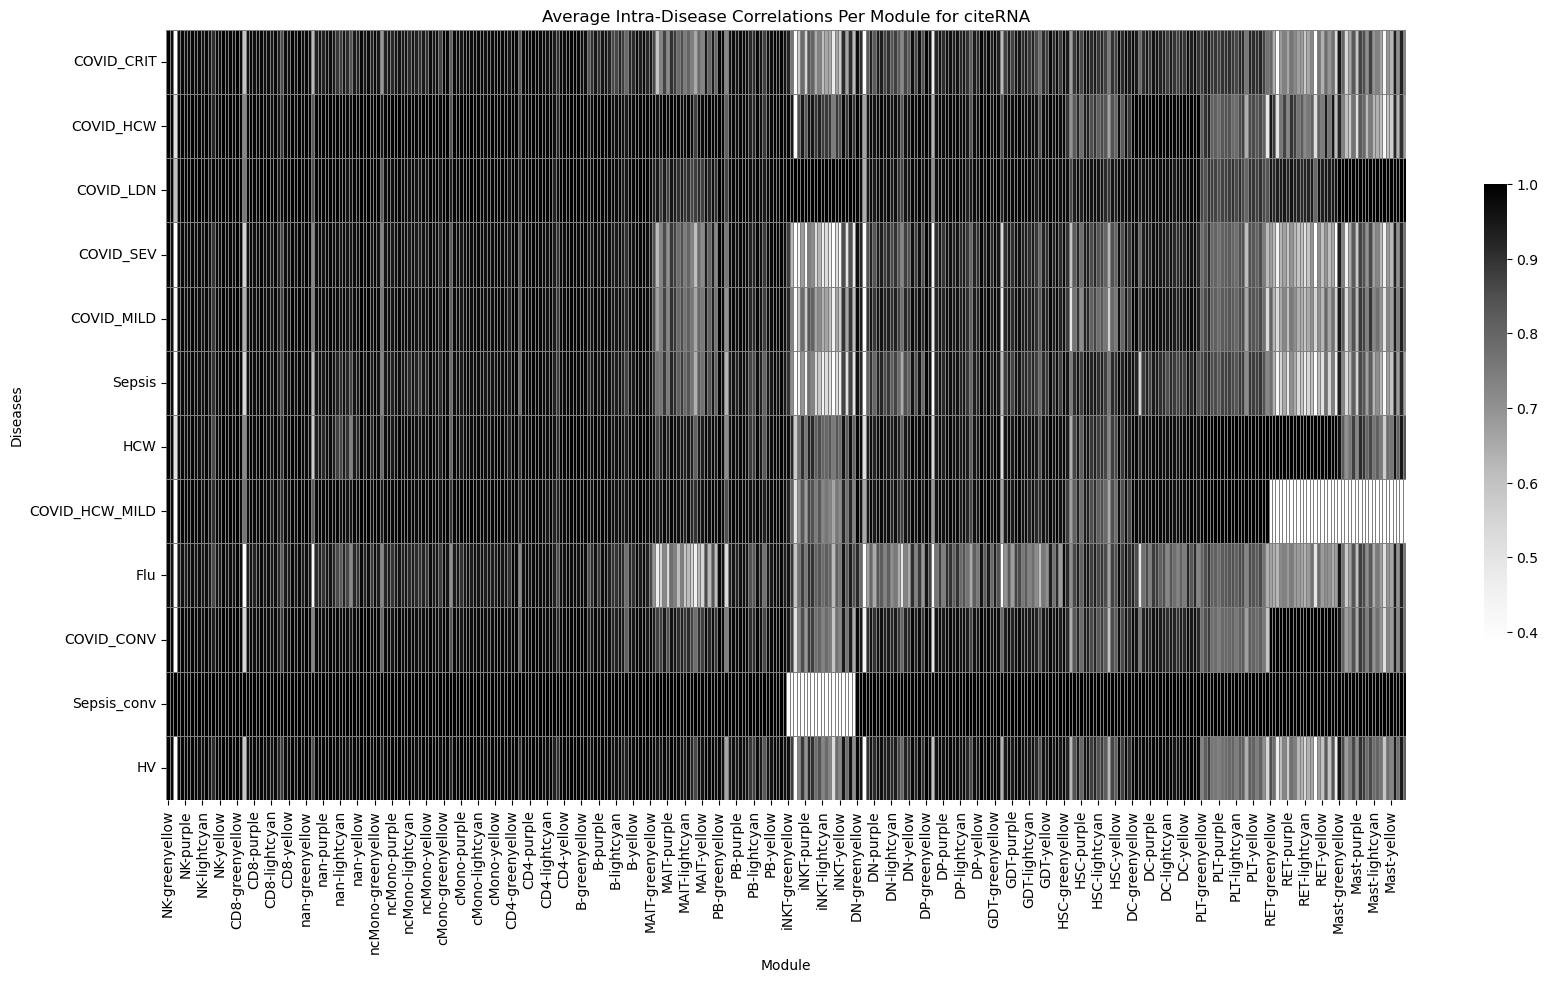

In [ ]:
# All Cell Types and Diseases: Average Correlation between Patients of the Same Disease
module_intra_disease_avg = {m:[0] * len(diseases) for m in citeRNA_disease_clusters_corr.keys() } # For every module and every disease, we compute ome average value, which is the average 
                                                                                                  # of all correlations in the matrix of that disease for that specific module.

for m in citeRNA_disease_clusters_corr.keys():
    for i, disease in enumerate(diseases):
        if (not (m.find("iNKT") > -1 and disease == "Sepsis_conv") and
            not (m.find("RET") > -1 and disease == "COVID_HCW_MILD") and 
            not (m.find("Mast") > -1 and disease == "COVID_HCW_MILD")):
            module_intra_disease_avg[m][i] = citeRNA_disease_clusters_corr[m]["intra_diseases"][disease].mean().mean()
        
df = pd.DataFrame(data = module_intra_disease_avg, index = diseases)

fig, ax = plt.subplots(figsize=(20,10))  
sb.heatmap(df, cmap ='Greys',  robust = True, linewidth=0.4, linecolor = "grey", cbar_kws={"shrink": 0.6}, ax = ax)
plt.title("Average Intra-Disease Correlations Per Module for citeRNA")

plt.ylabel("Diseases")
plt.xlabel("Module")


Text(0.5, 1.5, 'Simple Disease-Cell-Type Correlations in citeRNA \n with Hierachical Clustering Based on \n Correlation and no Normalization')

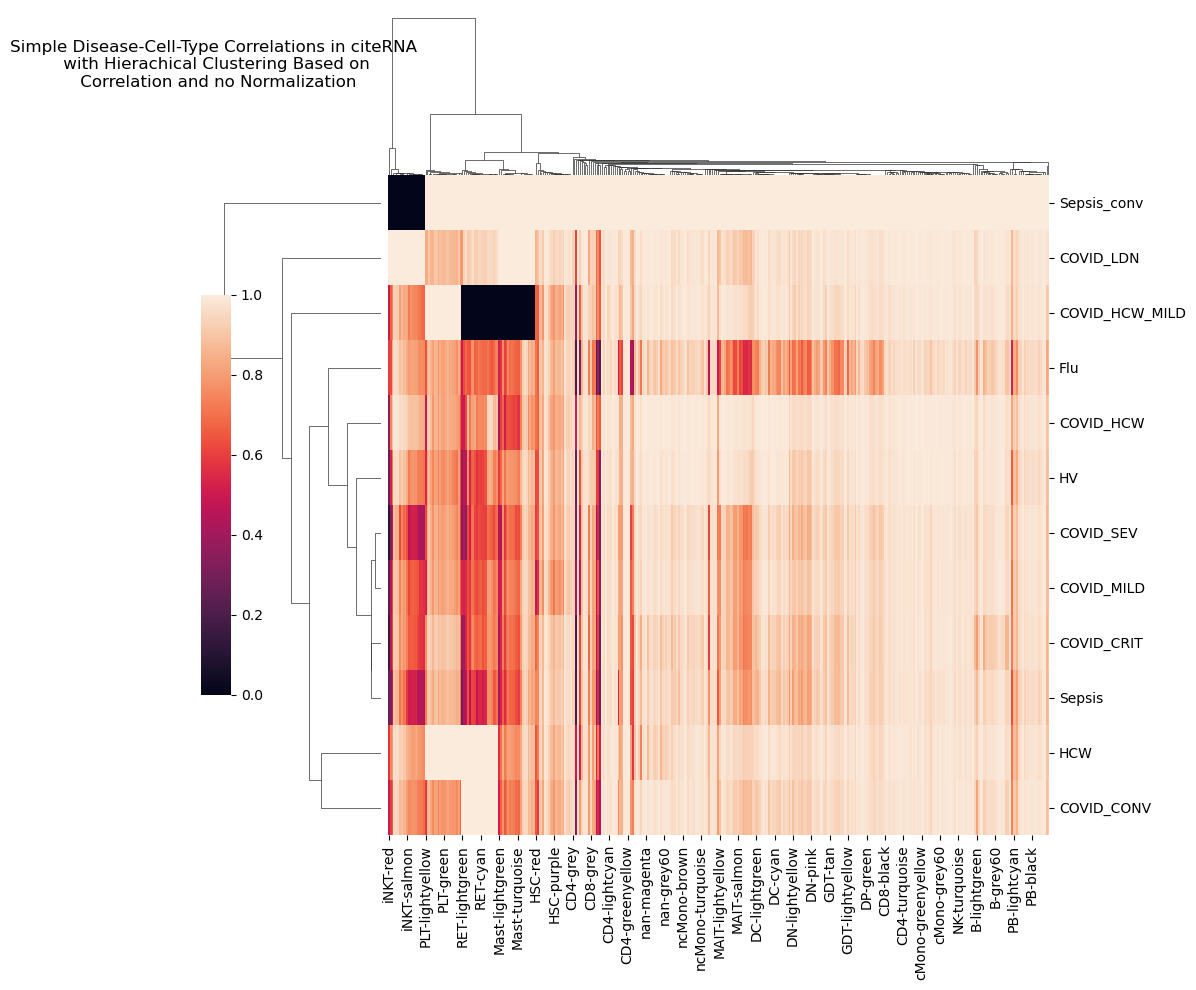

In [ ]:
sb.clustermap(df, metric="correlation", method="single", cbar_pos=(0, .3, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations in citeRNA \n with Hierachical Clustering Based on \n Correlation and no Normalization", y = 1.5)

Text(0.5, 1.3, 'Simple Disease-Cell-Type Correlations \n in citeRNA with \n Two-Way Hierachical Clustering')

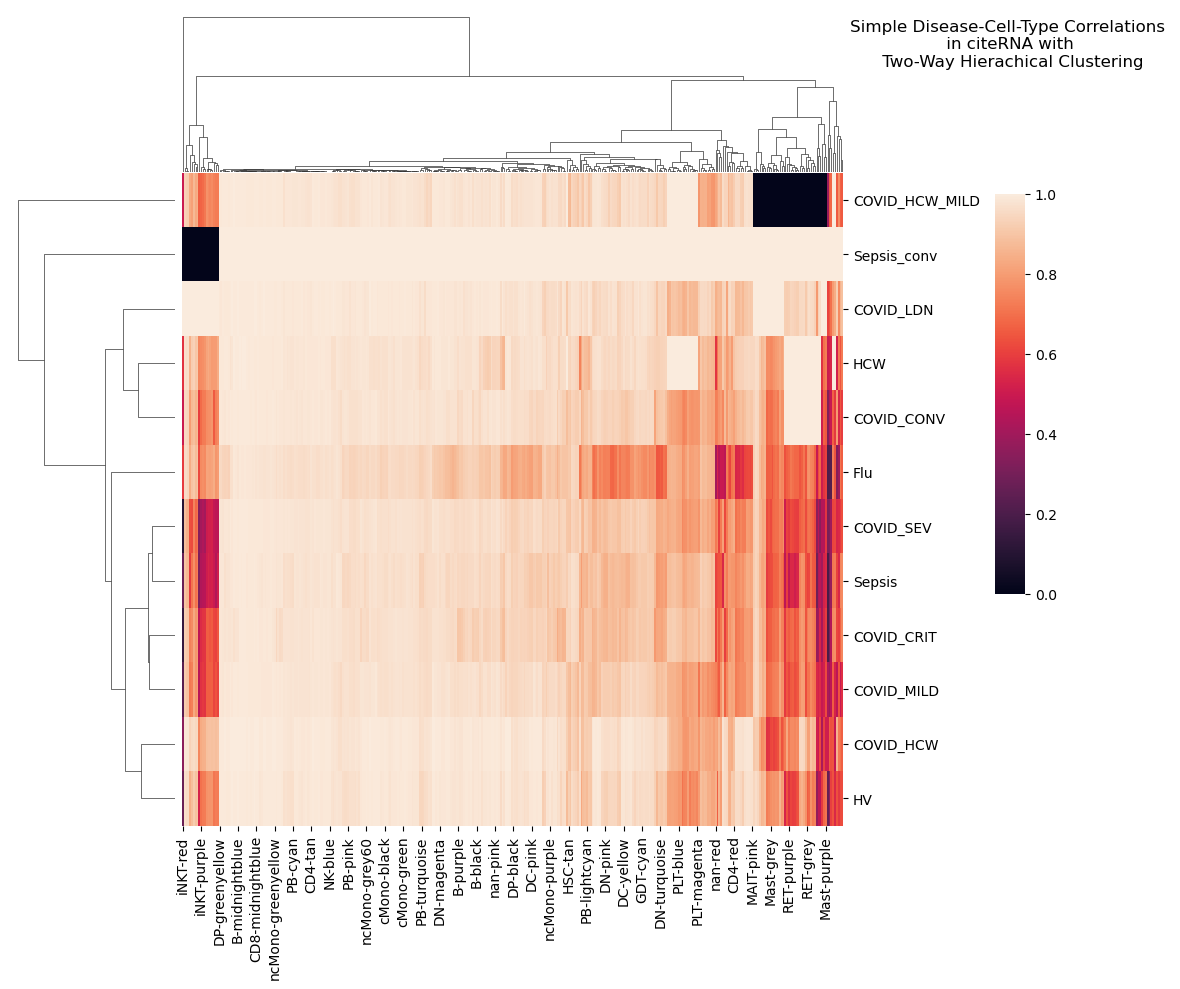

In [ ]:
sb.clustermap(df, cbar_pos=(1, .4, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations \n in citeRNA with \n Two-Way Hierachical Clustering", y = 1.3)

Text(0.5, 80.7222222222222, 'Module')

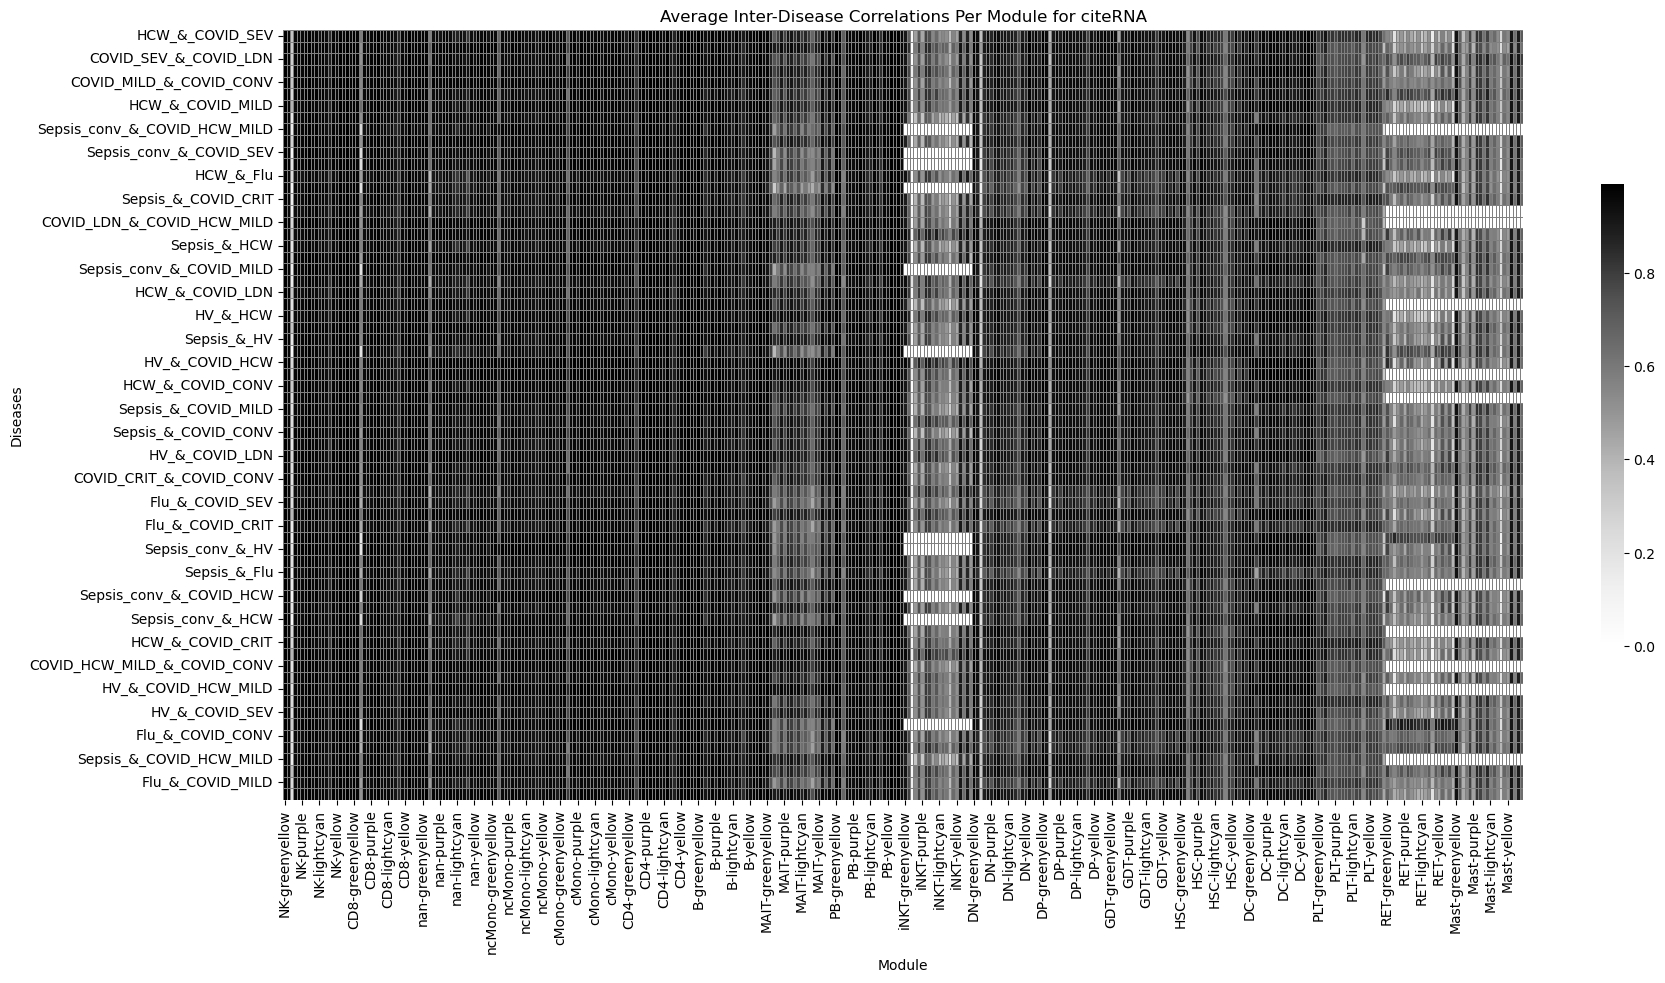

In [ ]:
# Avergae Correlation of the Patients of two different diseases
module_inter_disease_avg = {ct:[0] * len(disease_pairs) for ct in citeRNA_disease_clusters_corr.keys() }

for m in citeRNA_disease_clusters_corr.keys():
    for i, pair in enumerate(disease_pairs):
        if (not (m.find("iNKT") > -1 and pair.find("Sepsis_conv") > -1) and
            not (m.find("RET") > -1 and pair.find("COVID_HCW_MILD") > -1) and 
            not (m.find("Mast") > -1 and pair.find("COVID_HCW_MILD") > -1 )):
            module_inter_disease_avg[m][i] = citeRNA_disease_clusters_corr[m]["inter_diseases"][pair].mean().mean()
        
df = pd.DataFrame(data = module_inter_disease_avg, index = disease_pairs)

fig, ax = plt.subplots(figsize=(20,10))  
sb.heatmap(df, cmap ='Greys',  robust = True, linewidth=0.4, linecolor = "grey", cbar_kws={"shrink": 0.6}, ax = ax)

plt.title("Average Inter-Disease Correlations Per Module for citeRNA")

plt.ylabel("Diseases")
plt.xlabel("Module")


Text(0.5, 80.7222222222222, 'Module')

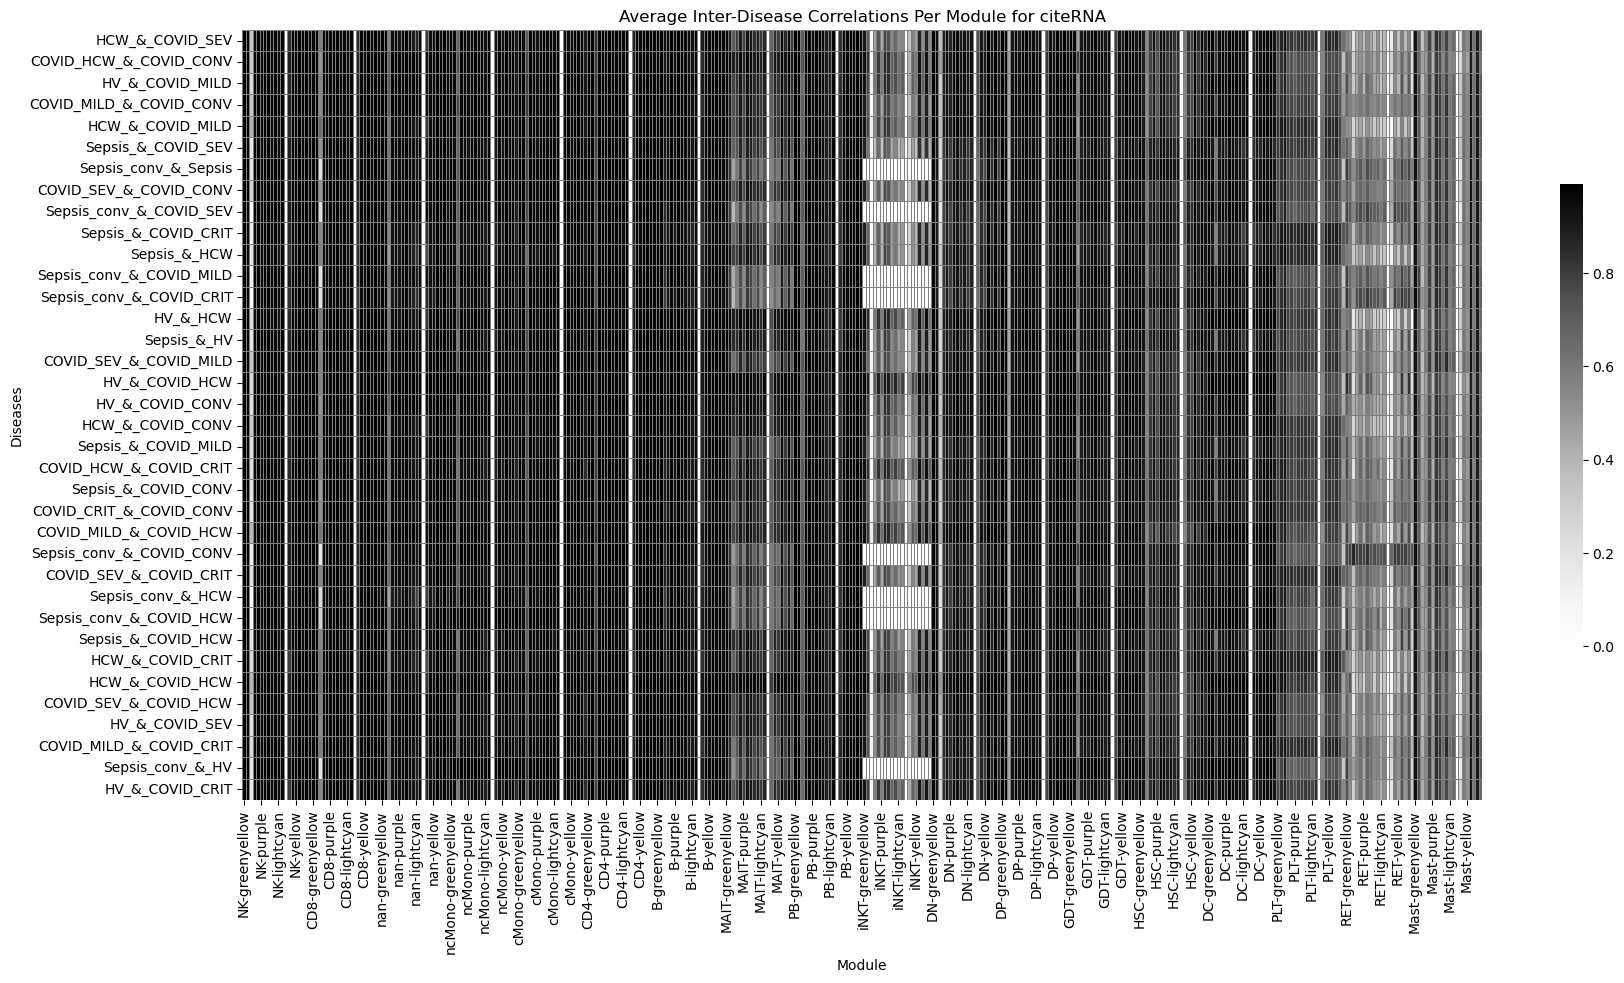

In [ ]:
# Avergae Correlation of the Patients of two different diseases
module_inter_disease_avg = {ct:[0] * len(disease_pairs) for ct in citeRNA_disease_clusters_corr.keys() }

for m in non_grey_keys:
    for i, pair in enumerate(disease_pairs):
        if (not (m.find("iNKT") > -1 and pair.find("Sepsis_conv") > -1) and
            not (m.find("RET") > -1 and pair.find("COVID_HCW_MILD") > -1) and 
            not (m.find("Mast") > -1 and pair.find("COVID_HCW_MILD") > -1 )):
            module_inter_disease_avg[m][i] = citeRNA_disease_clusters_corr[m]["inter_diseases"][pair].mean().mean()
        
df = pd.DataFrame(data = module_inter_disease_avg, index = disease_pairs)

fig, ax = plt.subplots(figsize=(20,10))  
sb.heatmap(df, cmap ='Greys',  robust = True, linewidth=0.4, linecolor = "grey", cbar_kws={"shrink": 0.6}, ax = ax)

plt.title("Average Inter-Disease Correlations Per Module for citeRNA")

plt.ylabel("Diseases")
plt.xlabel("Module")


/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.5, 'Simple Disease-Cell-Type Correlations in citeRNA \n with Hierachical Clustering Based on \n Correlation and no Normalization')

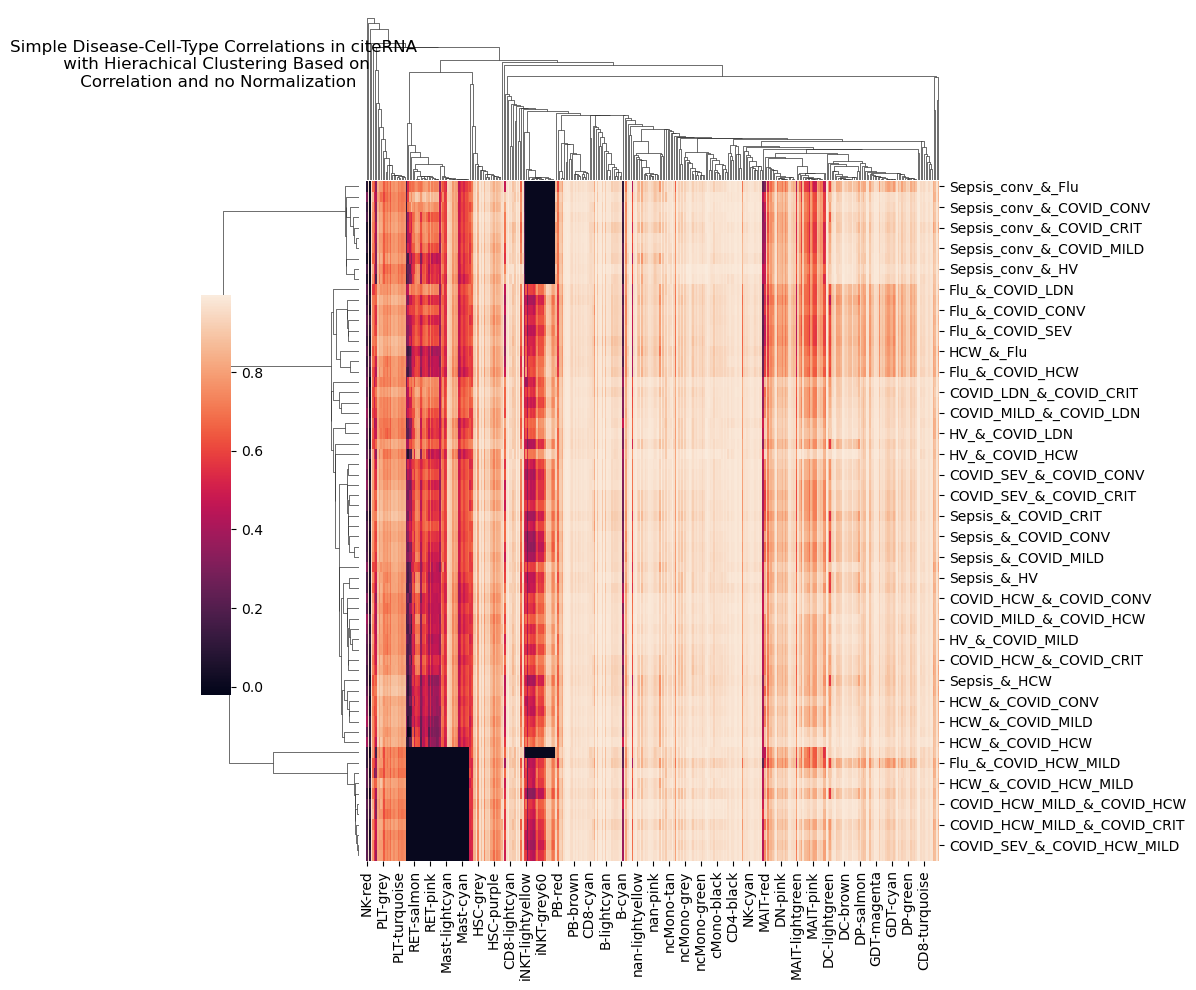

In [ ]:
sb.clustermap(df, metric="correlation", method="single", cbar_pos=(0, .3, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations in citeRNA \n with Hierachical Clustering Based on \n Correlation and no Normalization", y = 1.5)

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.3, 'Simple Disease-Cell-Type Correlations \n in citeRNA with \n Two-Way Hierachical Clustering')

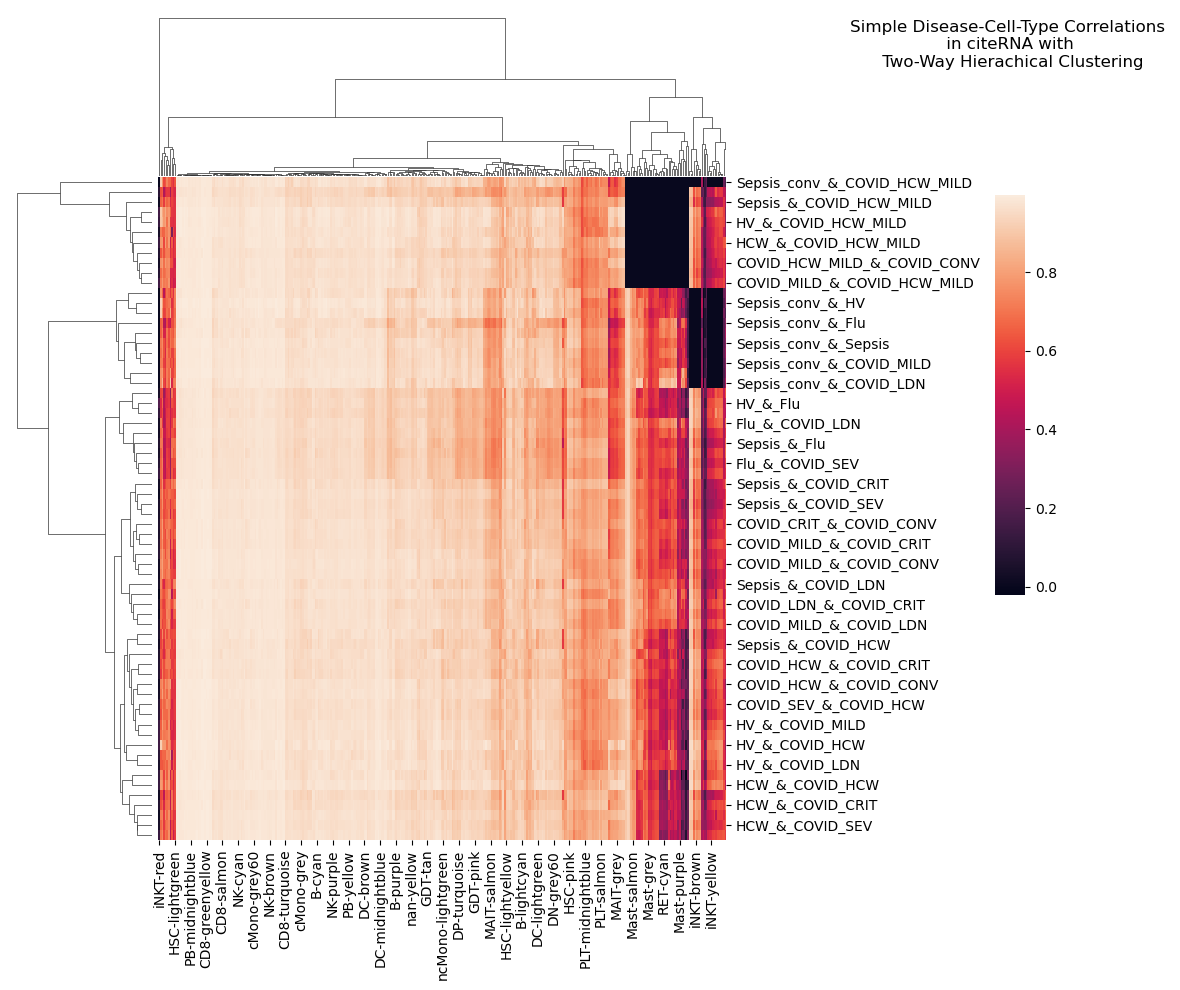

In [ ]:
sb.clustermap(df, cbar_pos=(1, .4, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations \n in citeRNA with \n Two-Way Hierachical Clustering", y = 1.3)

### ADT

#### Heatmaps

In [ ]:
diseases = list(adt_disease_clusters_corr[list(adt_disease_clusters_corr.keys())[0]]["all"].index.unique())
for i in range(1, len(list(adt_disease_clusters_corr.keys()))):
    key = list(adt_disease_clusters_corr.keys())[i]
    diseases = diseases + list((adt_disease_clusters_corr[key]["all"].index.unique()))
diseases = list(set(diseases))

In [ ]:
disease_pairs = list(adt_disease_clusters_corr[list(adt_disease_clusters_corr.keys())[0]]["inter_diseases"].keys())
for i in range(1, len(list(adt_disease_clusters_corr.keys()))):
    key = list(adt_disease_clusters_corr.keys())[i]
    disease_pairs = disease_pairs + list((adt_disease_clusters_corr[key]["inter_diseases"].keys()))
disease_pairs = list(set(disease_pairs))

Text(0.5, 126.62810457516339, 'Cell Types')

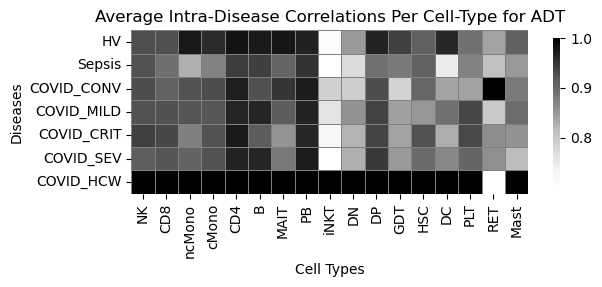

In [ ]:
# All Cell Types and Diseases: Average Correlation between Patients of the Same Disease
cell_type_intra_disease_avg = {ct:[0] * len(diseases) for ct in adt_disease_clusters_corr.keys()}

for ct in adt_disease_clusters_corr.keys():
    for i, disease in enumerate(diseases):
        if (not (ct == "iNKT" and disease == "Sepsis_conv") and 
        not (ct == "RET" and disease == "COVID_HCW_MILD") and
        not (ct == "RET" and disease == "COVID_HCW") and # should be added only if woking through the  base 75 patients
        not (ct == "Mast" and disease == "COVID_HCW_MILD")): # These diseases do not exist for these cell types
            cell_type_intra_disease_avg[ct][i] = adt_disease_clusters_corr[ct]["intra_diseases"][disease].mean().mean()
        
df = pd.DataFrame(data =cell_type_intra_disease_avg, index = diseases)

sb.heatmap(df, cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.4})
plt.title("Average Intra-Disease Correlations Per Cell-Type for ADT")

plt.ylabel("Diseases")
plt.xlabel("Cell Types")

Text(0.5, 1.3, 'Simple Disease-Cell-Type Correlations \n in ADT with \n Two-Way Hierachical Clustering')

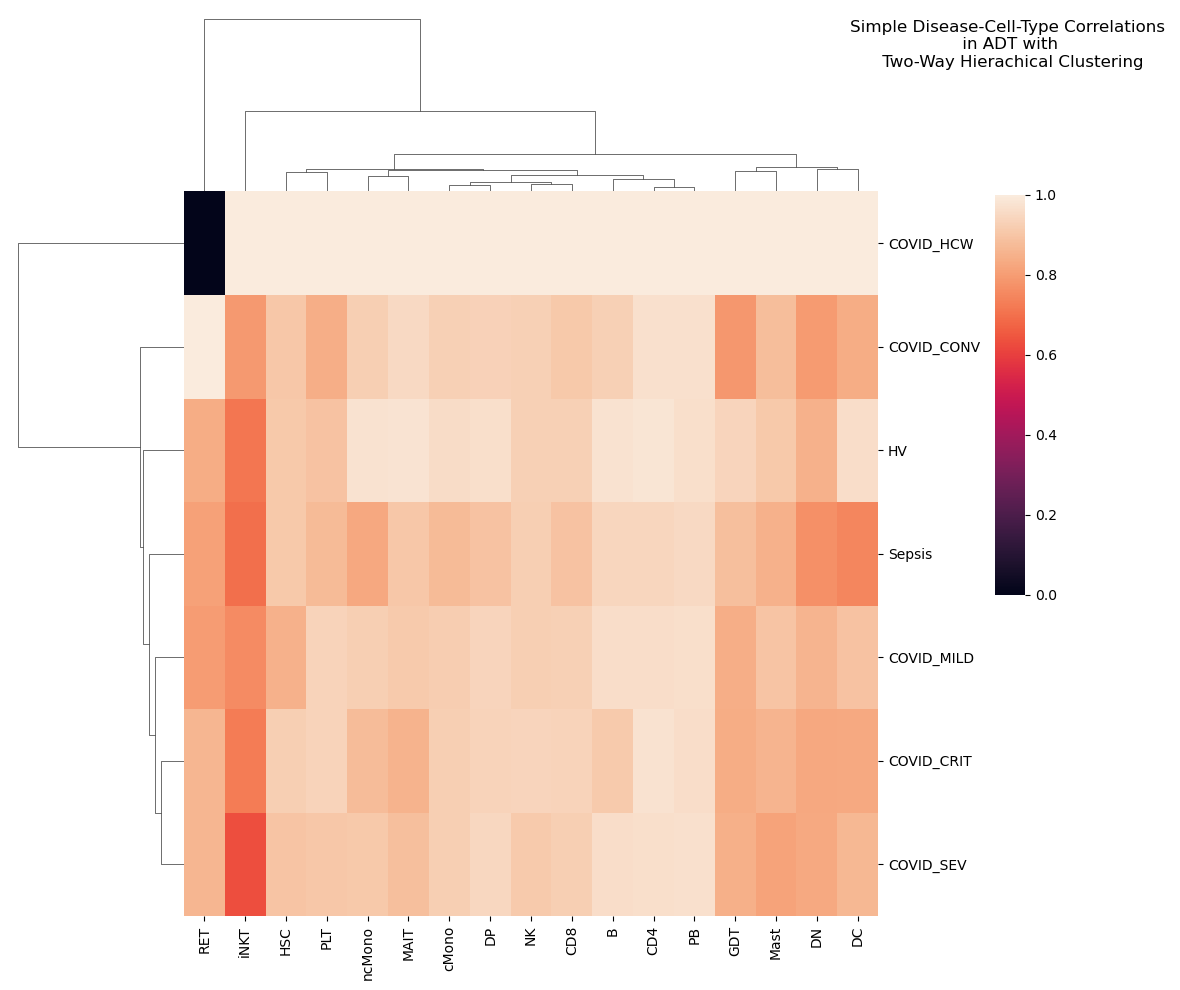

In [ ]:
sb.clustermap(df, cbar_pos=(1, .4, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations \n in ADT with \n Two-Way Hierachical Clustering", y = 1.3)

Text(0.5, 1.5, 'Simple Disease-Cell-Type Correlations in ADT \n with Hierachical Clustering Based on \n Correlation and no Normalization')

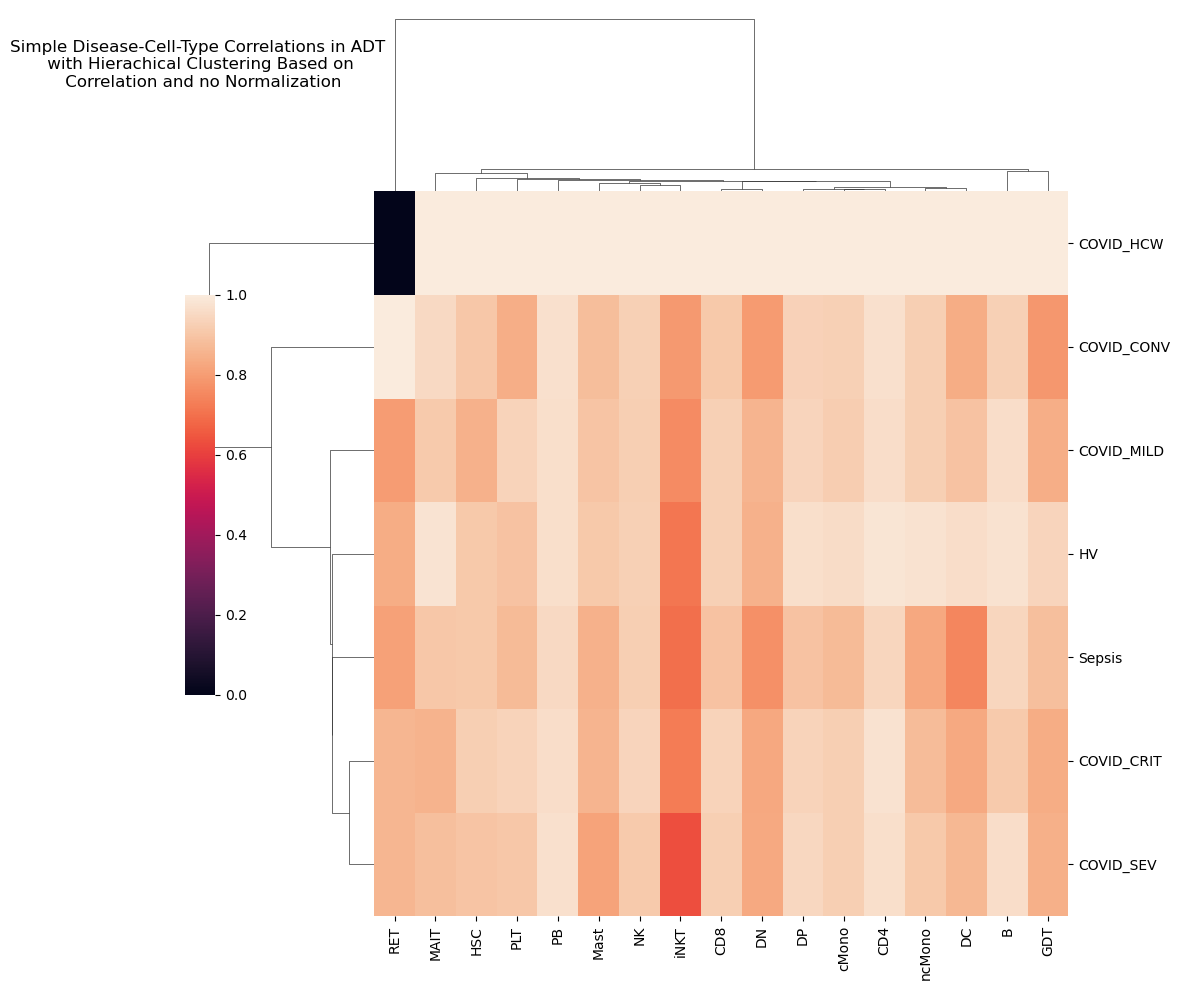

In [ ]:
sb.clustermap(df, metric="correlation", method="single", cbar_pos=(0, .3, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations in ADT \n with Hierachical Clustering Based on \n Correlation and no Normalization", y = 1.5)

Text(0.5, 23.52222222222222, 'Cell Types')

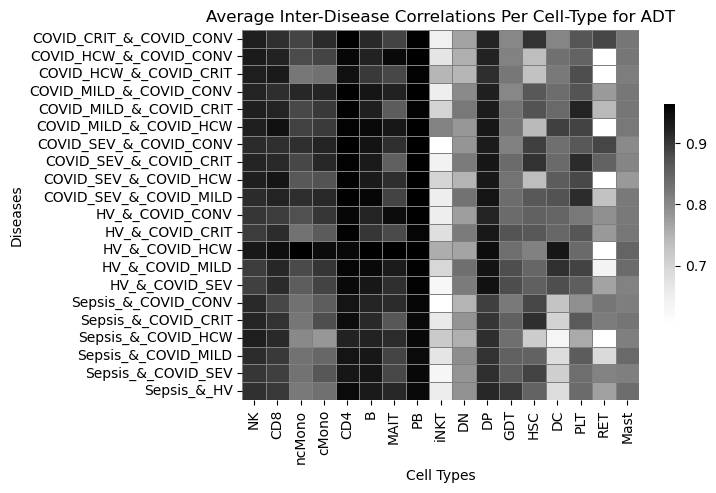

In [ ]:
# Avergae Correlation of the Patients of two different diseases
disease_pairs = list(adt_disease_clusters_corr[list(adt_disease_clusters_corr.keys())[0]]["inter_diseases"].keys())
cell_type_intra_disease_avg = {ct:[0] * len(disease_pairs) for ct in adt_disease_clusters_corr.keys() }

for ct in adt_disease_clusters_corr.keys():
    if not (str(ct) == "nan"):
        for i, pair in enumerate(disease_pairs):
            if (not (ct == "iNKT" and pair.find("Sepsis_conv") > -1) and 
            not (ct == "RET" and pair.find("COVID_HCW_MILD") >  -1) and
            not (ct == "RET" and pair.find("COVID_HCW") >  -1) and # should be added for the base 75 patients
            not (ct == "Mast" and pair.find("COVID_HCW_MILD") > -1 )): # These diseases do not exist for these cell types
                cell_type_intra_disease_avg[ct][i] = adt_disease_clusters_corr[ct]["inter_diseases"][pair].mean().mean()
        
df = pd.DataFrame(data =cell_type_intra_disease_avg, index = disease_pairs)

sb.heatmap(df, cmap ='Greys',  robust = True, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.6})
plt.title("Average Inter-Disease Correlations Per Cell-Type for ADT")
plt.ylabel("Diseases")
plt.xlabel("Cell Types")

Text(0.5, 1.5, 'Simple Disease-Cell-Type Correlations in ADT \n with Hierachical Clustering Based on \n Correlation and no Normalization')

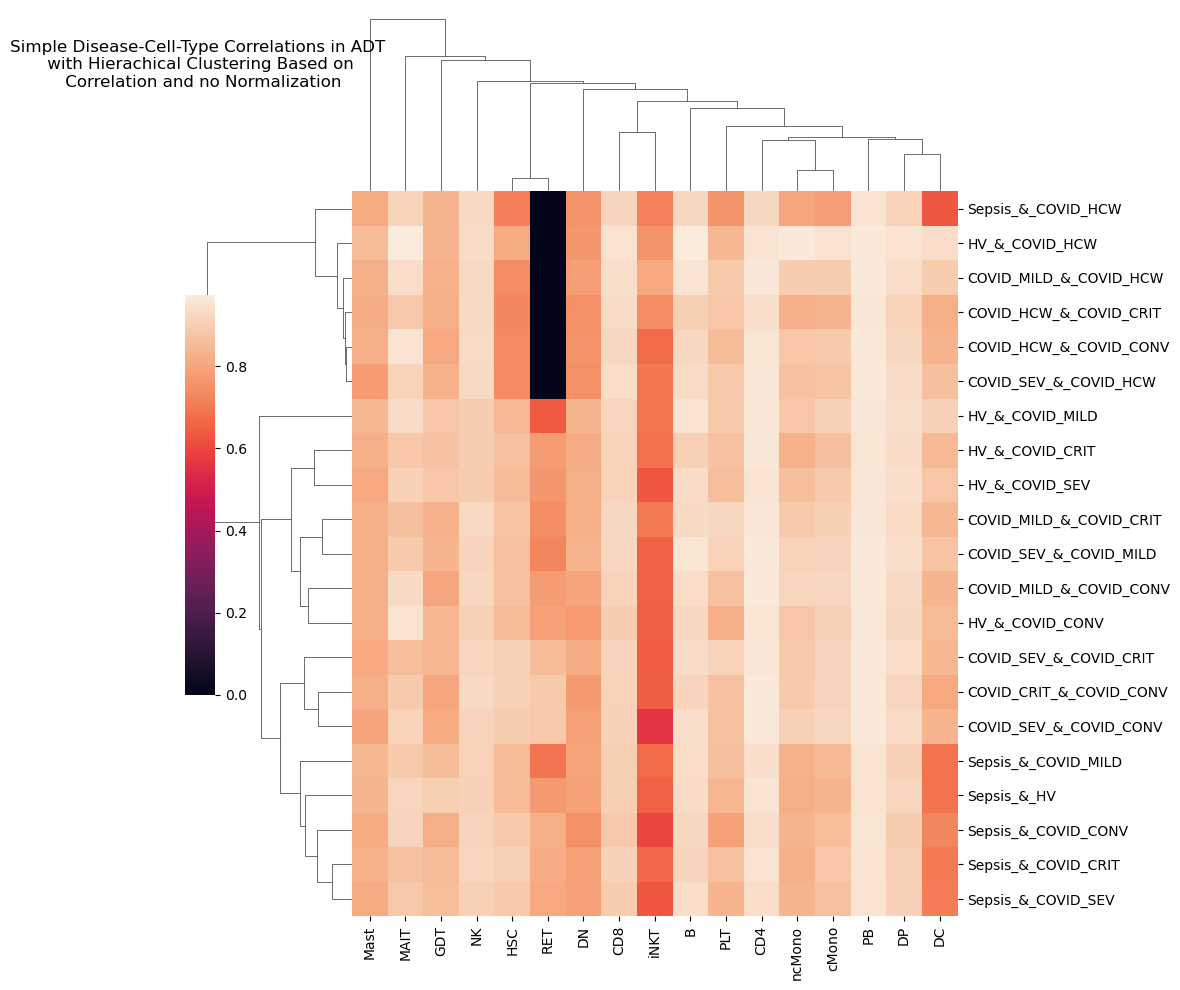

In [ ]:
sb.clustermap(df, metric="correlation", method="single", cbar_pos=(0, .3, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations in ADT \n with Hierachical Clustering Based on \n Correlation and no Normalization", y = 1.5)

Text(0.5, 1.3, 'Simple Disease-Cell-Type Correlations \n in ADT with \n Two-Way Hierachical Clustering')

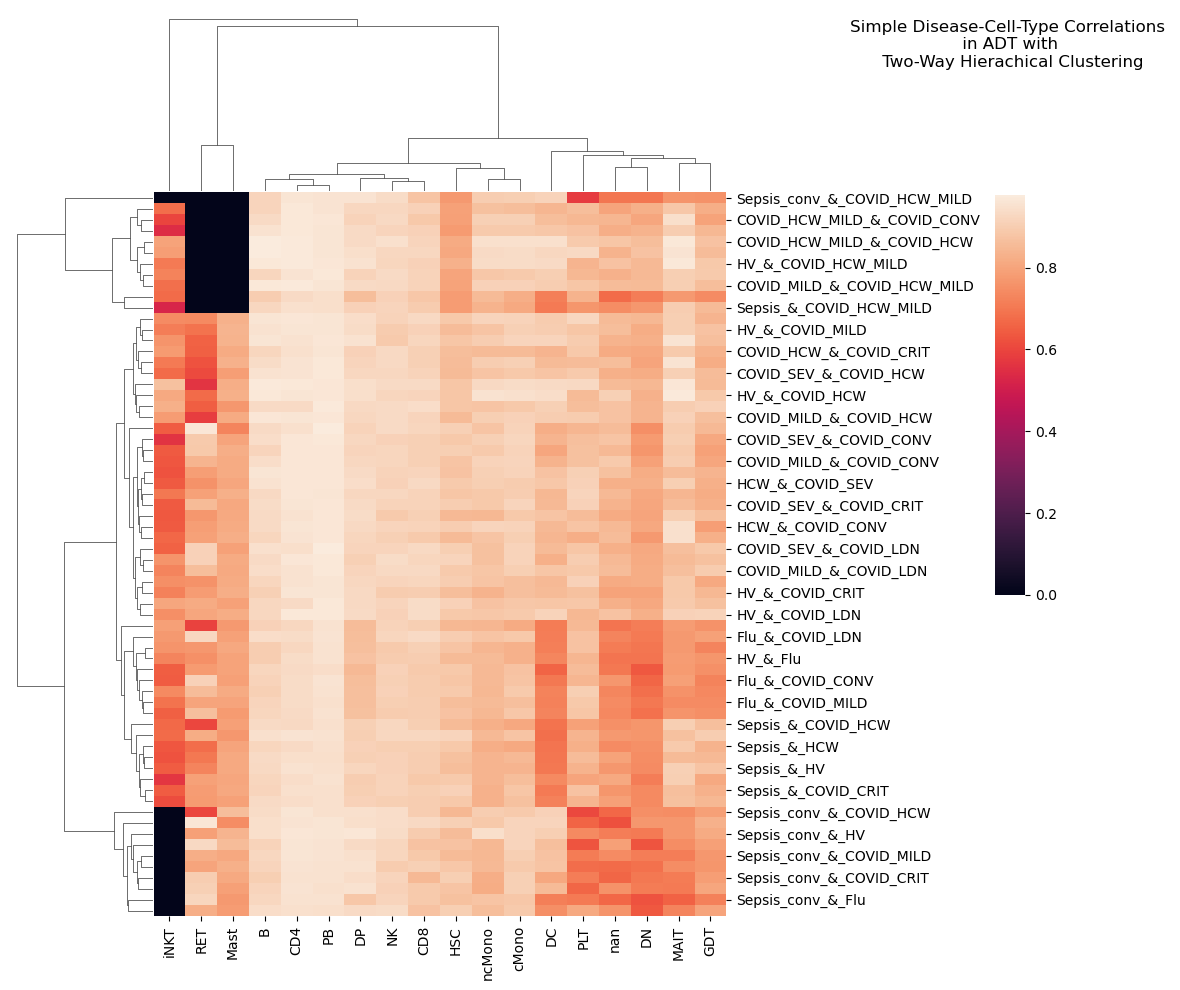

In [ ]:
sb.clustermap(df, cbar_pos=(1, .4, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations \n in ADT with \n Two-Way Hierachical Clustering", y = 1.3)

### FACS

#### Heatmaps

Text(0.5, 1.3, 'Simple Patient-Disease Correlations in Facs with \n Two-Way Hierachical Clustering')

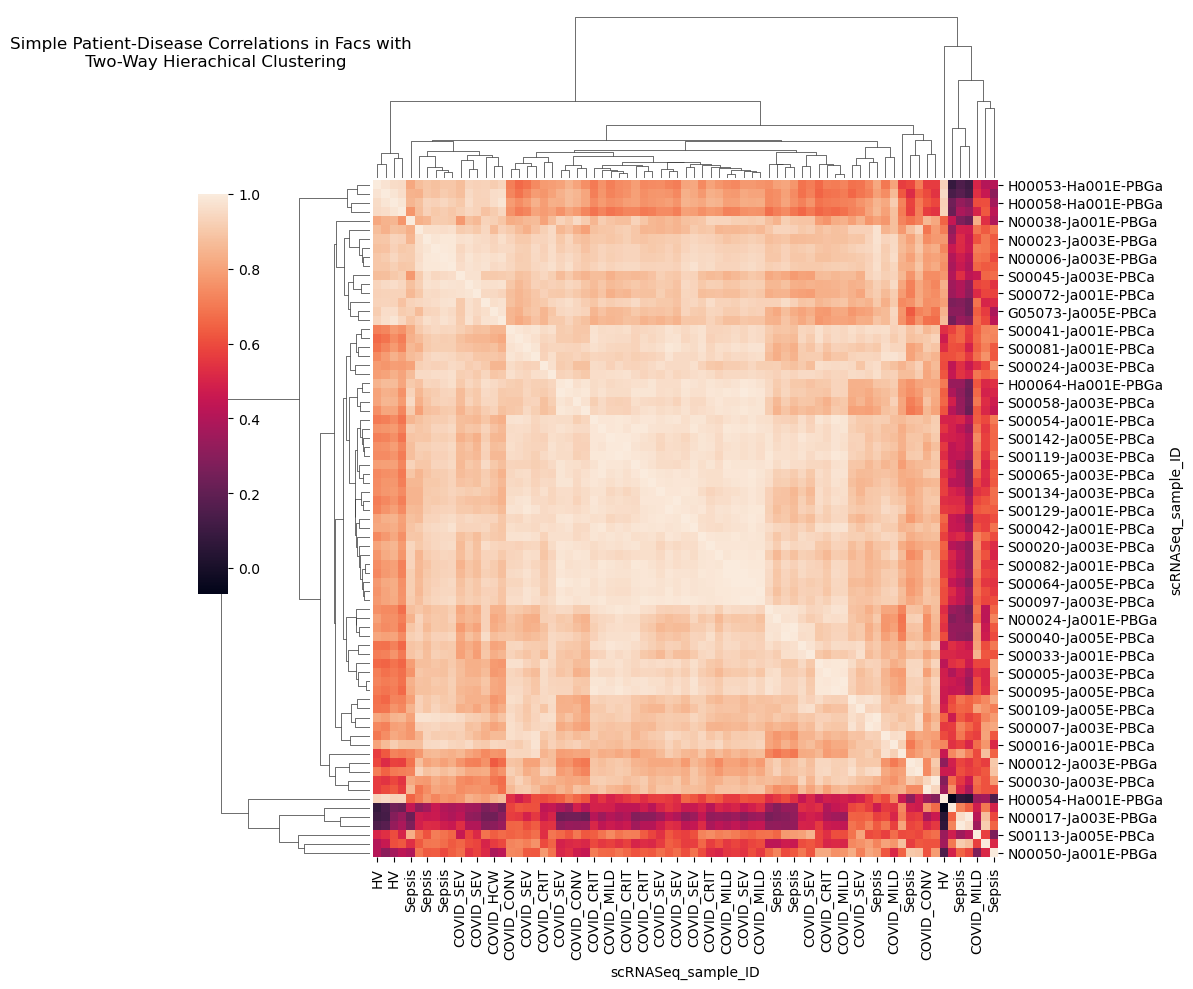

In [ ]:
sb.clustermap(corr_p_d_facs, cbar_pos=(0, .4, .03, .4))
plt.title("Simple Patient-Disease Correlations in Facs with \n Two-Way Hierachical Clustering", y = 1.3)

Text(0.5, 734.4444444444445, 'Patients')

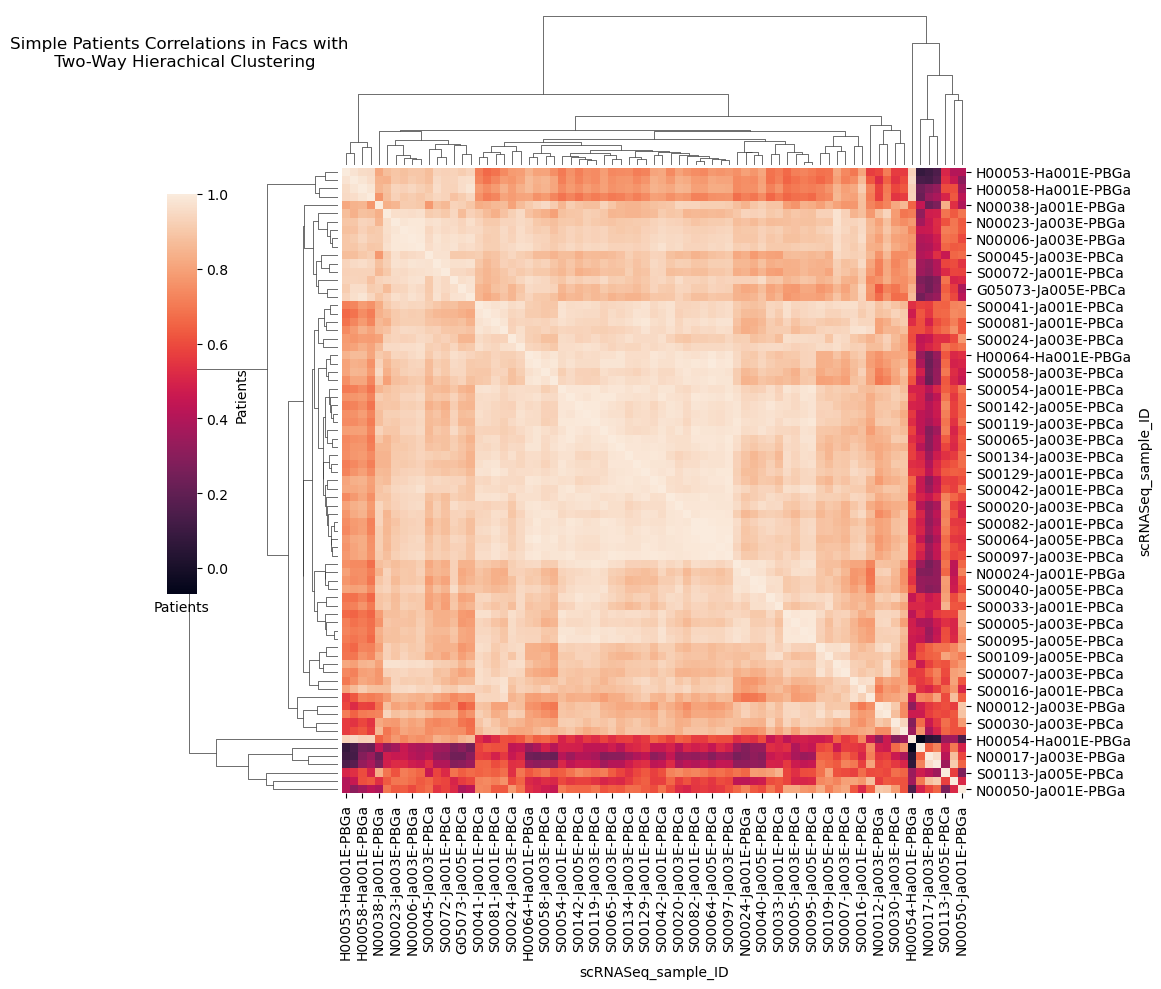

In [ ]:
sb.clustermap(corr_p_facs, cbar_pos=(0, .4, .03, .4))
plt.title("Simple Patients Correlations in Facs with \n Two-Way Hierachical Clustering", y = 1.3)
plt.ylabel("Patients")
plt.xlabel("Patients")

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 734.4444444444445, 'Patients')

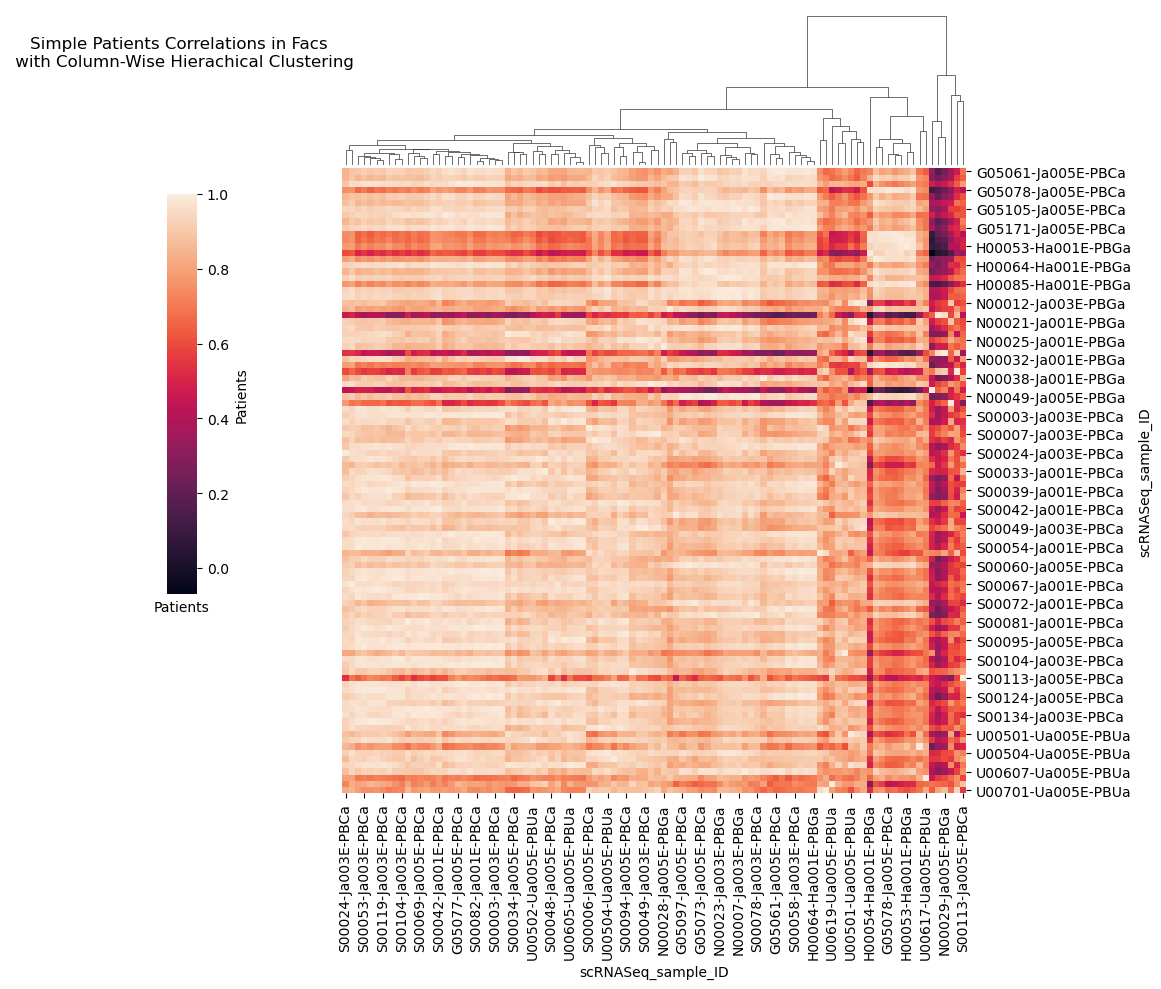

In [ ]:
sb.clustermap(corr_p_facs, cbar_pos=(0, .4, .03, .4), row_cluster=False,)
plt.title("Simple Patients Correlations in Facs \n with Column-Wise Hierachical Clustering" , y = 1.3)
plt.ylabel("Patients")
plt.xlabel("Patients")

Text(0.5, 155.72222222222217, 'Patients')

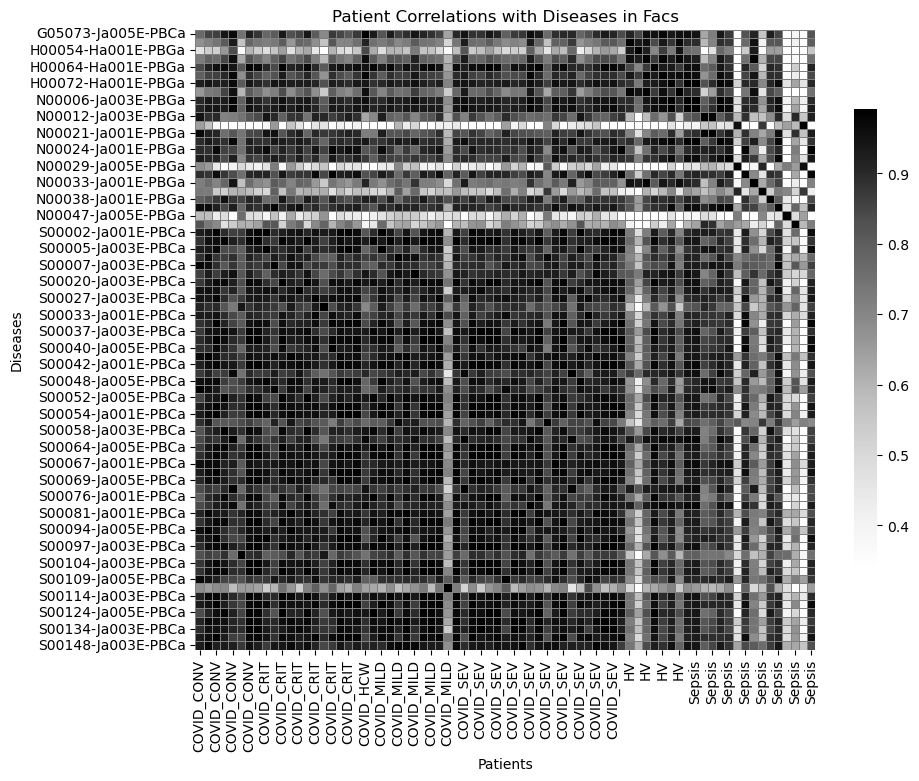

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
sb.heatmap(corr_p_d_facs, cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.6})
plt.title("Patient Correlations with Diseases in Facs")
plt.ylabel("Diseases")
plt.xlabel("Patients")

Text(0.5, 640.8888888888889, 'Patients')

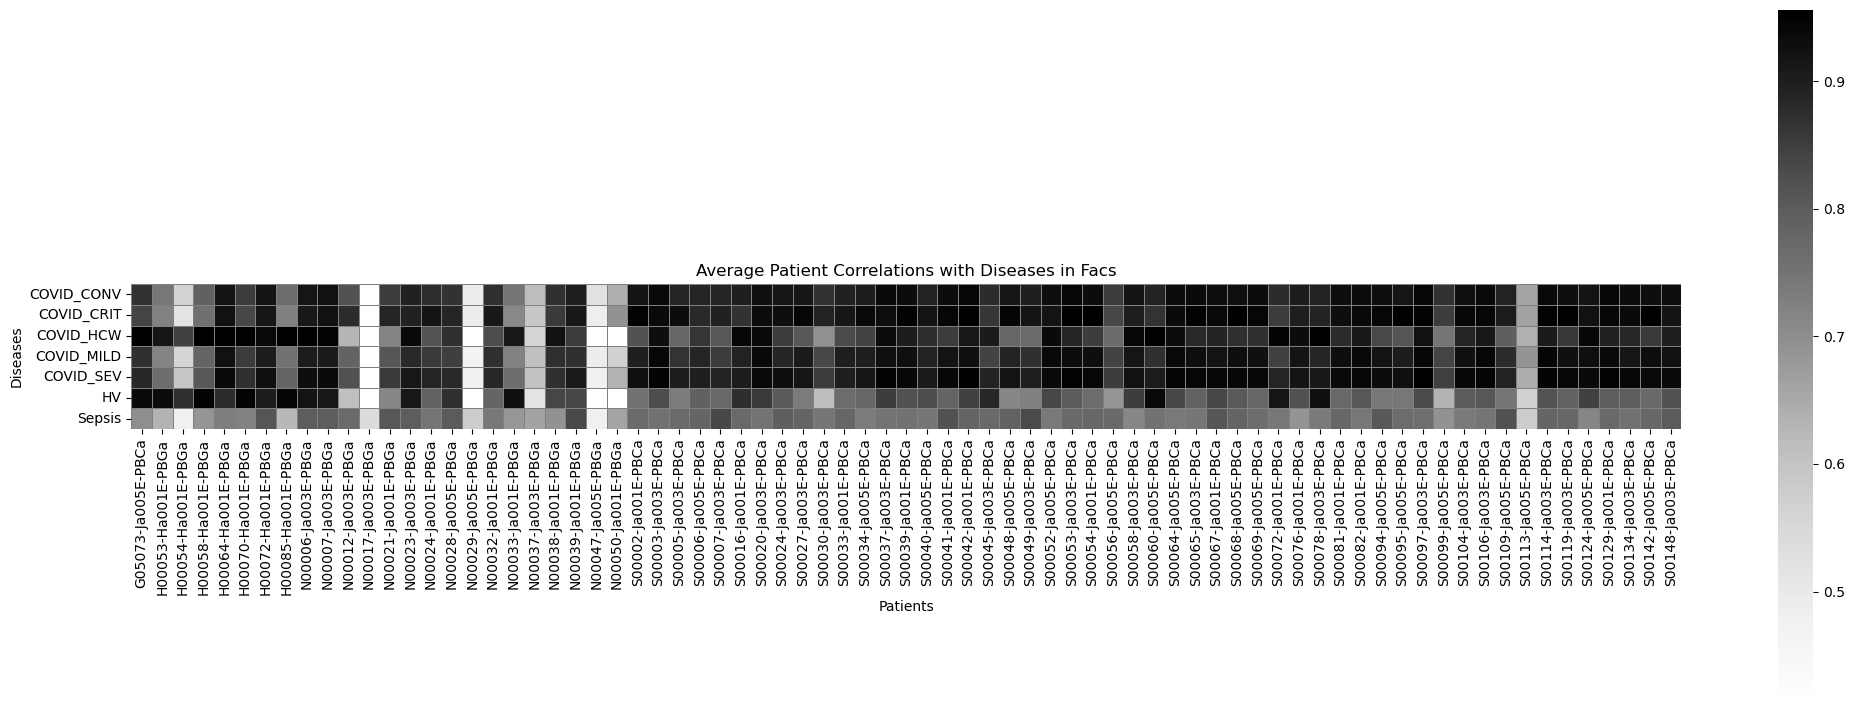

In [ ]:
fig,ax=plt.subplots(figsize=(25,15))
sb.heatmap(corr_p_d_facs.transpose().groupby("scRNASeq_sample_ID").mean(), cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.6}, )
plt.title("Average Patient Correlations with Diseases in Facs")
plt.ylabel("Diseases")
plt.xlabel("Patients")

Text(0.5, 155.72222222222217, 'Patients')

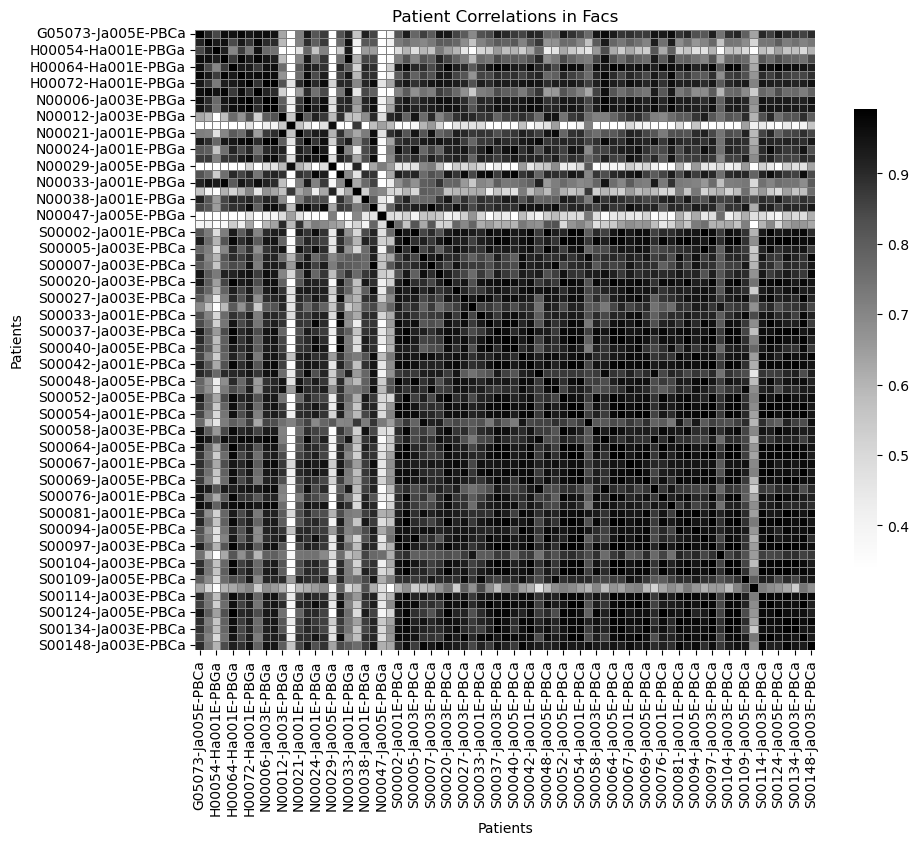

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
sb.heatmap(corr_p_facs, cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.6})
plt.title("Patient Correlations in Facs")
plt.ylabel("Patients")
plt.xlabel("Patients")

Text(0.5, 155.72222222222217, 'Diseases')

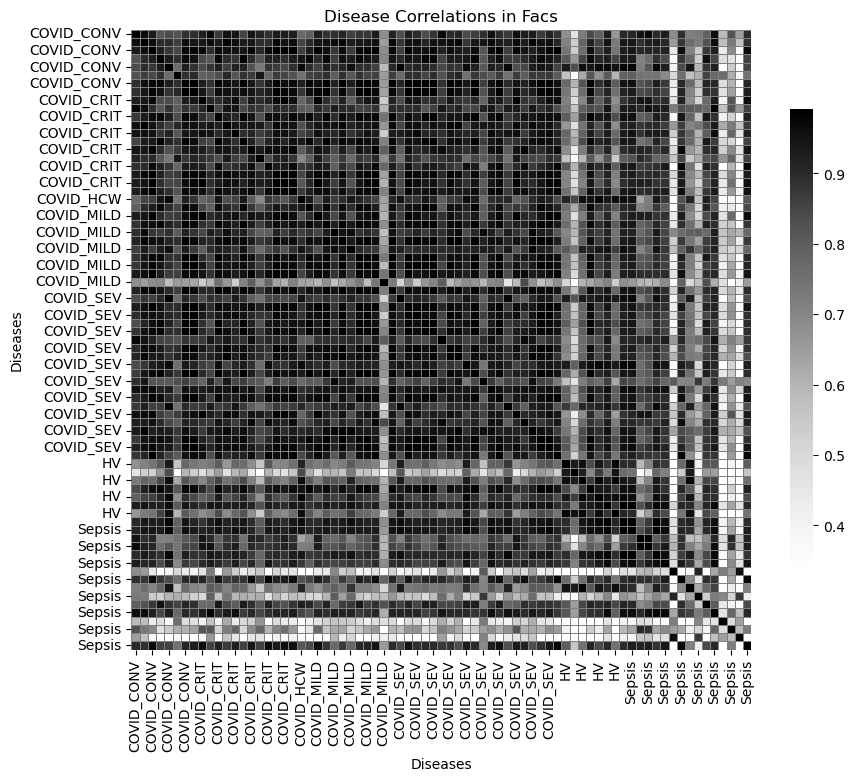

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
sb.heatmap(corr_d_facs, cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.6})
plt.title("Disease Correlations in Facs")
plt.ylabel("Diseases")
plt.xlabel("Diseases")

#### Histograms

In [ ]:
COVID_CRIT_COVID_CONV = facs_disease_clusters_corr["inter_diseases"]["COVID_CRIT_&_COVID_CONV"].to_numpy().flatten()
COVID_HCW_COVID_CRIT = facs_disease_clusters_corr["inter_diseases"]["COVID_HCW_&_COVID_CRIT"].to_numpy().flatten()
COVID_SEV_COVID_HCW = facs_disease_clusters_corr["inter_diseases"]["COVID_SEV_&_COVID_HCW"].to_numpy().flatten()
HV_COVID_SEV = facs_disease_clusters_corr["inter_diseases"]["HV_&_COVID_SEV"].to_numpy().flatten()
Sepsis_conv_HCW = facs_disease_clusters_corr["inter_diseases"]["Sepsis_&_COVID_HCW"].to_numpy().flatten()


HV = facs_disease_clusters_corr["intra_diseases"]["HV"].to_numpy().flatten()
COVID_SEV = facs_disease_clusters_corr["intra_diseases"]["COVID_SEV"].to_numpy().flatten()
COVID_CRIT = facs_disease_clusters_corr["intra_diseases"]["COVID_CRIT"].to_numpy().flatten()
COVID_CONV = facs_disease_clusters_corr["intra_diseases"]["COVID_CONV"].to_numpy().flatten()
COVID_HCW = facs_disease_clusters_corr["intra_diseases"]["COVID_HCW"]
Sepsis = facs_disease_clusters_corr["intra_diseases"]["Sepsis"].to_numpy().flatten()

Text(0.5, 1.0, 'Disease Counts in Facs')

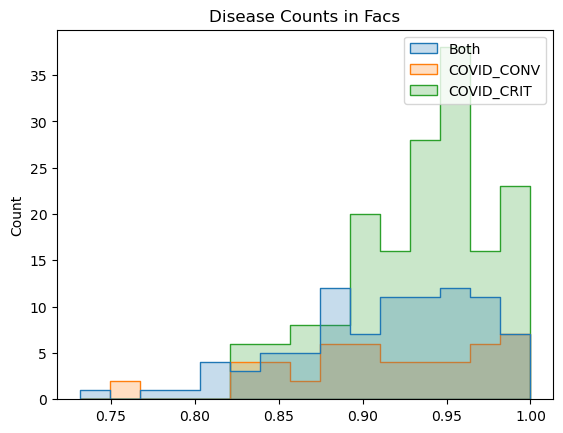

In [ ]:
sb.histplot(data={"Both": COVID_CRIT_COVID_CONV, "COVID_CONV": COVID_CONV, "COVID_CRIT": COVID_CRIT}, element="step",
    stat="count", common_norm=False, bins = 15)
plt.title("Disease Counts in Facs")

Text(0.5, 1.0, 'Disease Counts in Facs')

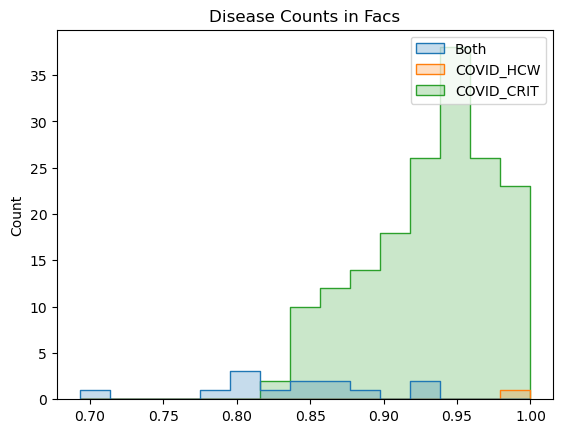

In [ ]:
sb.histplot(data={"Both": COVID_HCW_COVID_CRIT, "COVID_HCW": COVID_HCW, "COVID_CRIT": COVID_CRIT}, element="step",
    stat="count", common_norm=False, bins = 15)
plt.title("Disease Counts in Facs")

Text(0.5, 1.0, 'Disease Counts in Facs')

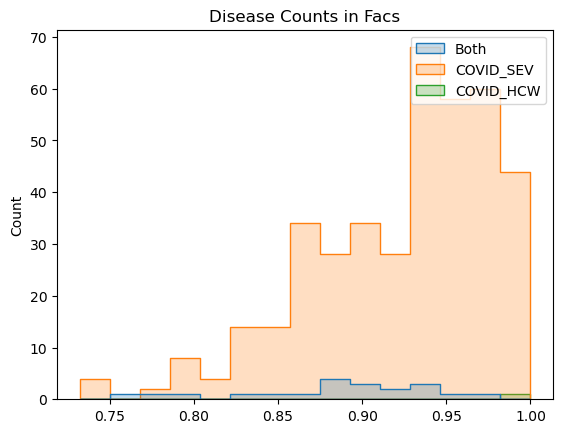

In [ ]:
sb.histplot(data={"Both": COVID_SEV_COVID_HCW, "COVID_SEV": COVID_SEV, "COVID_HCW": COVID_HCW}, element="step",
    stat="count", common_norm=False, bins = 15)
plt.title("Disease Counts in Facs")

Text(0.5, 1.0, 'Disease Counts in Facs')

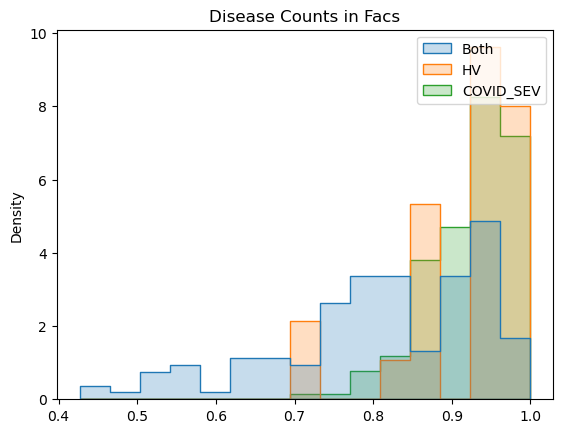

In [ ]:
sb.histplot(data={"Both": HV_COVID_SEV, "HV": HV, "COVID_SEV": COVID_SEV}, element="step",
    stat="density", common_norm=False, bins = 15)
plt.title("Disease Counts in Facs")

<Axes: ylabel='Density'>

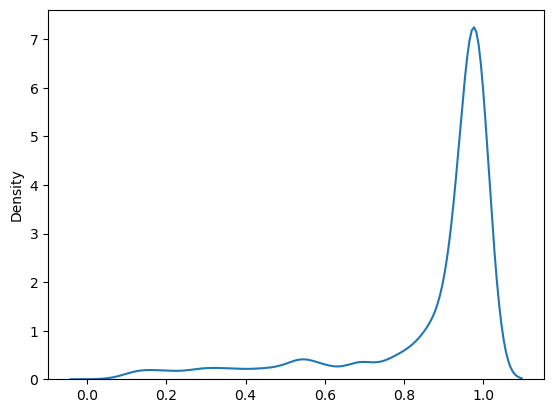

In [ ]:
sb.kdeplot(corr_p_luminex.to_numpy().flatten()) 

### bulkRNA

#### Heatmaps

In [ ]:
diseases = list(bulkRNA_disease_clusters_corr[list(bulkRNA_disease_clusters_corr.keys())[0]]["all"].index.unique())
for i in range(1, len(list(bulkRNA_disease_clusters_corr.keys()))):
    key = list(bulkRNA_disease_clusters_corr.keys())[i]
    diseases = diseases + list((bulkRNA_disease_clusters_corr[key]["all"].index.unique()))
diseases = list(set(diseases))

disease_pairs = list(bulkRNA_disease_clusters_corr[list(bulkRNA_disease_clusters_corr.keys())[0]]["inter_diseases"].keys())
for i in range(1, len(list(bulkRNA_disease_clusters_corr.keys()))):
    key = list(bulkRNA_disease_clusters_corr.keys())[i]
    disease_pairs = disease_pairs + list((bulkRNA_disease_clusters_corr[key]["inter_diseases"].keys()))
disease_pairs = list(set(disease_pairs))

Text(0.5, 23.52222222222222, 'Module')

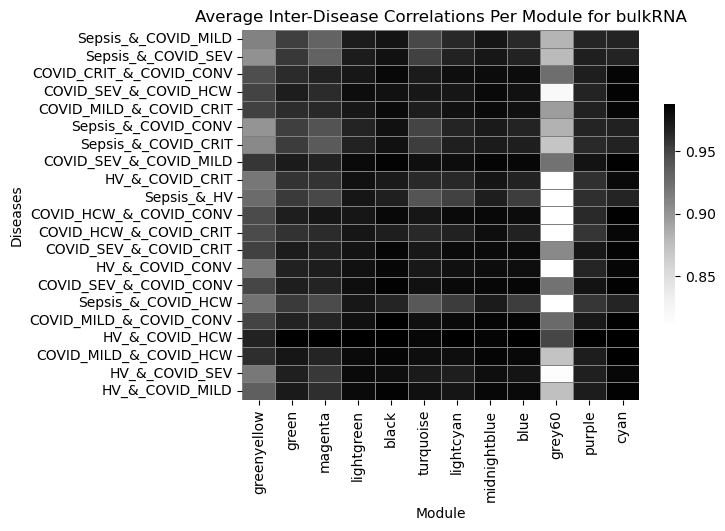

In [ ]:
# Avergae Correlation of the Patients of two different diseases
module_inter_disease_avg = {ct:[0] * len(disease_pairs) for ct in bulkRNA_disease_clusters_corr.keys() }

for m in bulkRNA_disease_clusters_corr.keys():
    for i, pair in enumerate(disease_pairs):
        module_inter_disease_avg[m][i] = bulkRNA_disease_clusters_corr[m]["inter_diseases"][pair].mean().mean()
        
df = pd.DataFrame(data = module_inter_disease_avg, index = disease_pairs)

sb.heatmap(df, cmap ='Greys',  robust = True, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.6})
plt.title("Average Inter-Disease Correlations Per Module for bulkRNA")

plt.ylabel("Diseases")
plt.xlabel("Module")


Text(0.5, 23.52222222222222, 'Module')

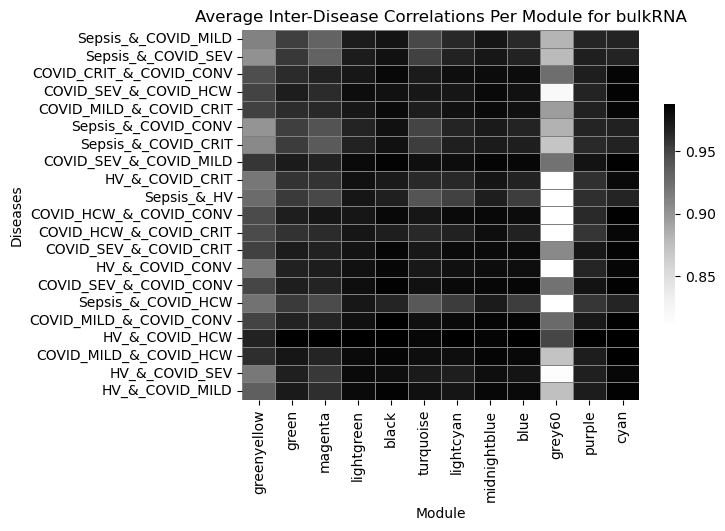

In [ ]:
cols = [c for c in df.columns if not c == "grey"] # Remove the noise

sb.heatmap(df[cols], cmap ='Greys',  robust = True, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.6})
plt.title("Average Inter-Disease Correlations Per Module for bulkRNA")

plt.ylabel("Diseases")
plt.xlabel("Module")

Text(0.5, 1.3, 'Simple Disease-Module Correlations \n in bulkRNA with \n Two-Way Hierachical Clustering')

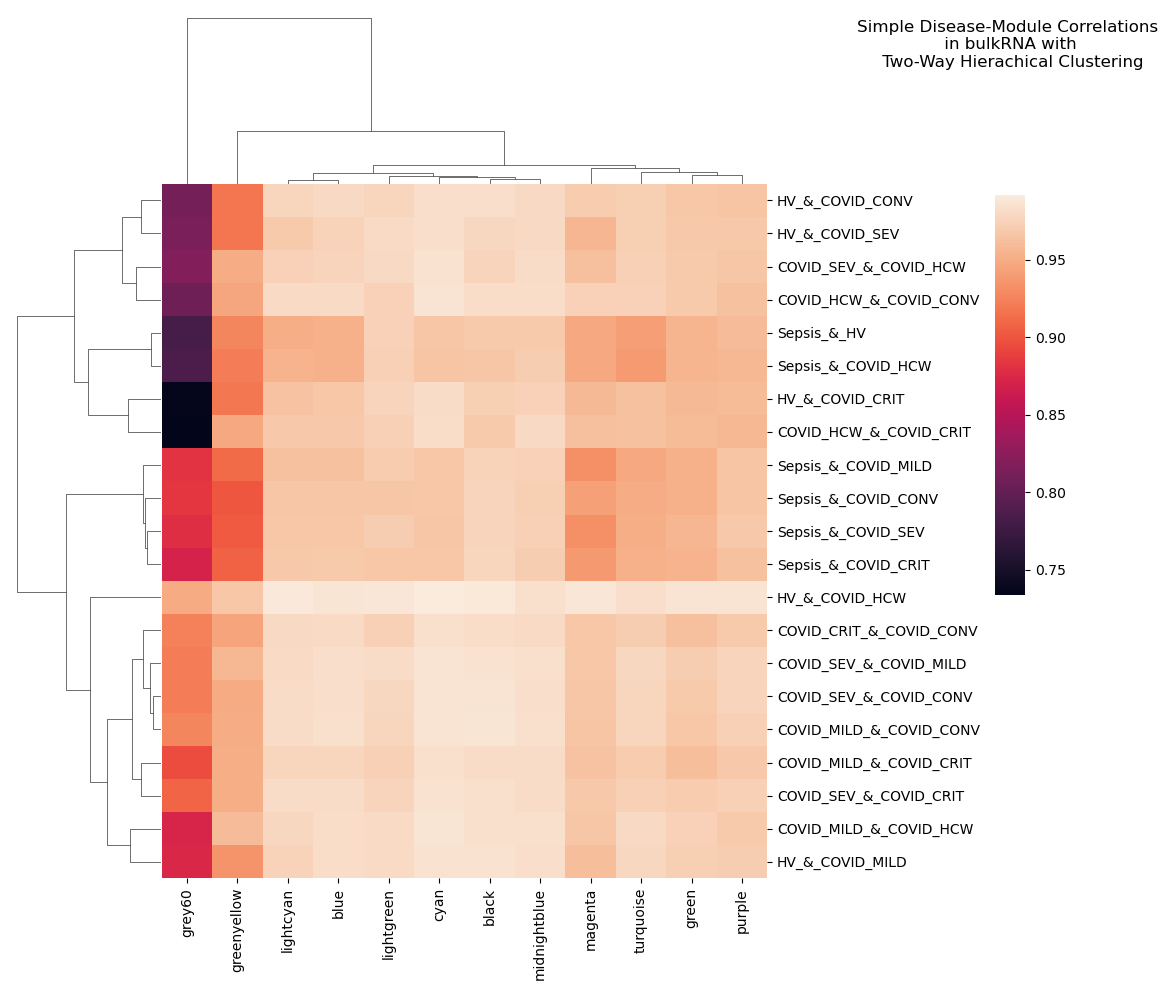

In [ ]:
sb.clustermap(df, cbar_pos=(1, .4, .03, .4))
plt.title("Simple Disease-Module Correlations \n in bulkRNA with \n Two-Way Hierachical Clustering", y = 1.3)

Text(0.5, 92.58888888888886, 'Module')

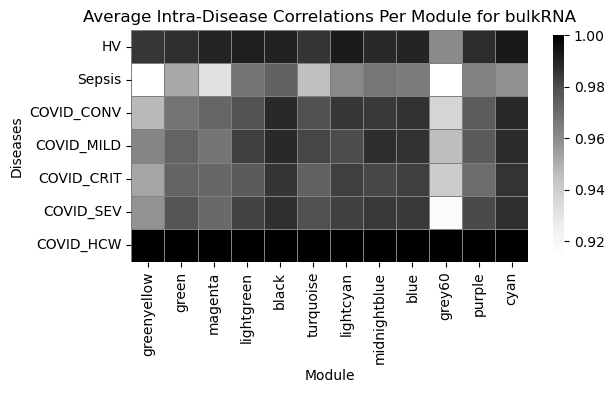

In [ ]:
# All Cell Types and Diseases: Average Correlation between Patients of the Same Disease
module_intra_disease_avg = {m:[0] * len(diseases) for m in bulkRNA_disease_clusters_corr.keys() }

for m in bulkRNA_disease_clusters_corr.keys():
    for i, disease in enumerate(diseases):
        module_intra_disease_avg[m][i] = bulkRNA_disease_clusters_corr[m]["intra_diseases"][disease].mean().mean()
        
df = pd.DataFrame(data = module_intra_disease_avg, index = diseases)

sb.heatmap(df, cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.6})
plt.title("Average Intra-Disease Correlations Per Module for bulkRNA")

plt.ylabel("Diseases")
plt.xlabel("Module")


Text(0.5, 23.52222222222222, 'Module')

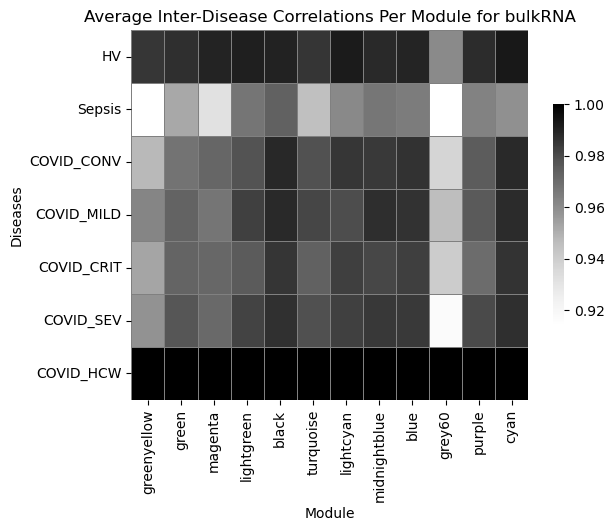

In [ ]:
cols = [c for c in df.columns if not c == "grey"] # Remove the noise

sb.heatmap(df[cols], cmap ='Greys',  robust = True, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.6})
plt.title("Average Inter-Disease Correlations Per Module for bulkRNA")

plt.ylabel("Diseases")
plt.xlabel("Module")

Text(0.5, 1.3, 'Simple Disease-Module Correlations \n in bulkRNA with \n Two-Way Hierachical Clustering')

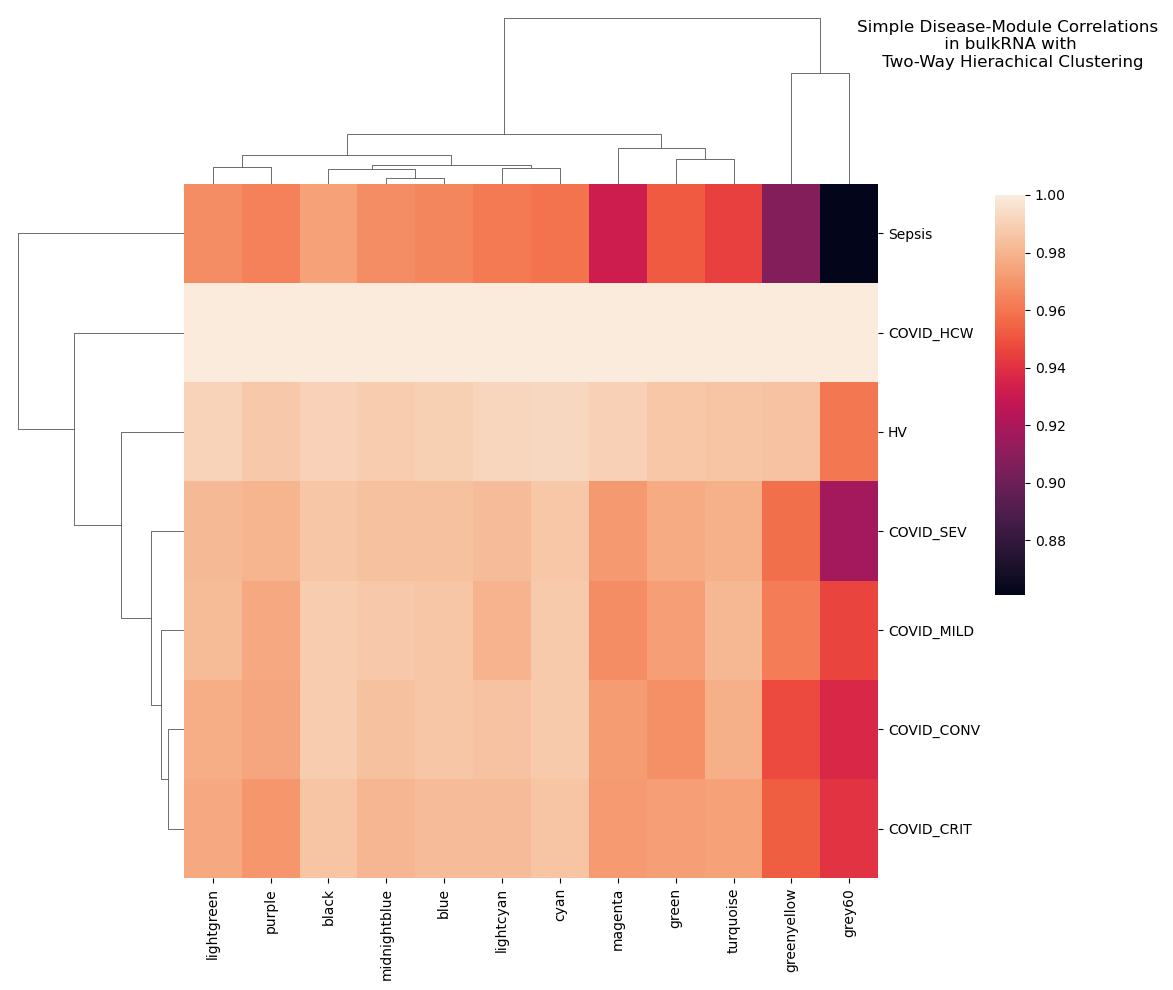

In [ ]:
sb.clustermap(df, cbar_pos=(1, .4, .03, .4))
plt.title("Simple Disease-Module Correlations \n in bulkRNA with \n Two-Way Hierachical Clustering", y = 1.3)

<Axes: >

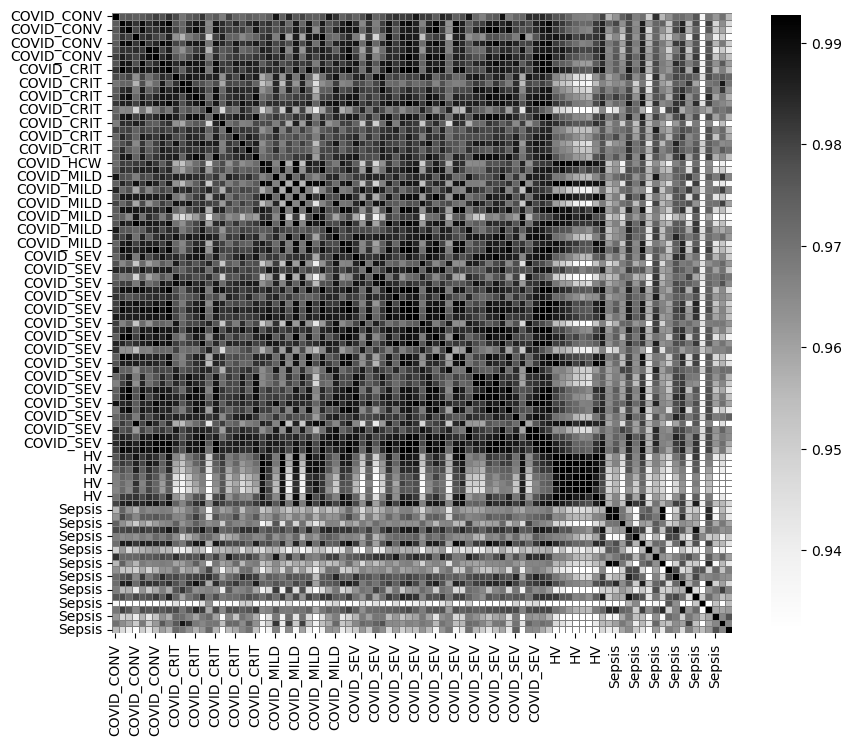

In [ ]:
# lightcyan
fig,ax=plt.subplots(figsize=(10,10))
sb.heatmap(bulkRNA_disease_clusters_corr["lightcyan"]["all"], cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.8})

<Axes: >

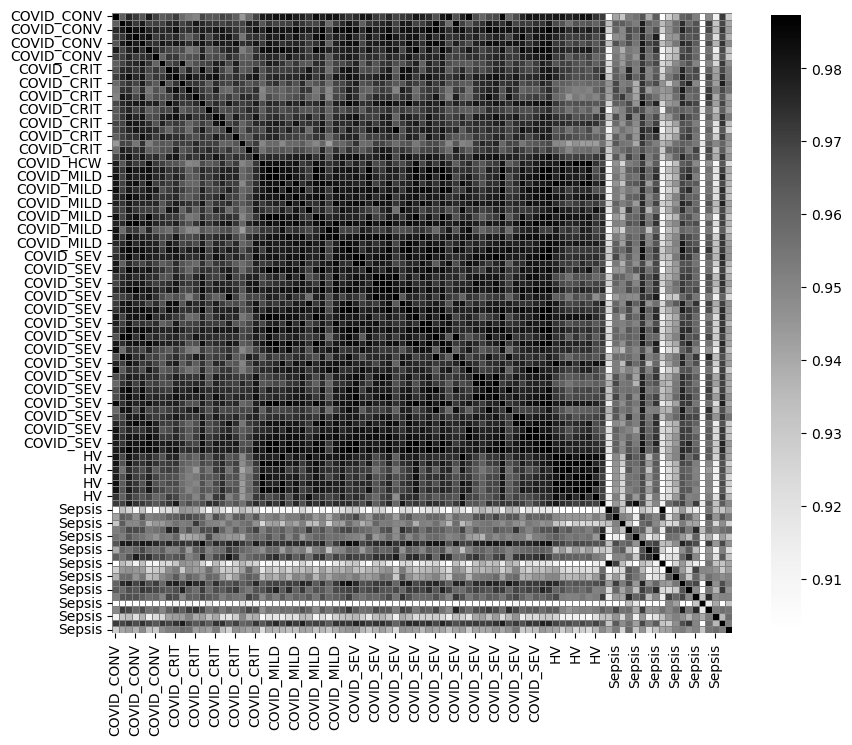

In [ ]:
# turquoise
fig,ax=plt.subplots(figsize=(10,10))
sb.heatmap(bulkRNA_disease_clusters_corr["turquoise"]["all"], cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.8})

#### Densities

In [ ]:
# cyan
Sepsis_HV = bulkRNA_disease_clusters_corr["cyan"]["inter_diseases"]['Sepsis_&_HV'].to_numpy().flatten()
COVID_MILD_COVID_CONV = bulkRNA_disease_clusters_corr["cyan"]["inter_diseases"]['COVID_MILD_&_COVID_CONV'].to_numpy().flatten()
Sepsis_COVID_SEV = bulkRNA_disease_clusters_corr["cyan"]["inter_diseases"]['Sepsis_&_COVID_SEV'].to_numpy().flatten()
HV_COVID_SEV = bulkRNA_disease_clusters_corr["cyan"]["inter_diseases"]['HV_&_COVID_SEV'].to_numpy().flatten()
COVID_SEV_COVID_CRIT = bulkRNA_disease_clusters_corr["cyan"]["inter_diseases"]['COVID_SEV_&_COVID_CRIT'].to_numpy().flatten()
HV_COVID_HCW = bulkRNA_disease_clusters_corr["cyan"]["inter_diseases"]['HV_&_COVID_HCW'].to_numpy().flatten()
COVID_CRIT_COVID_CONV = bulkRNA_disease_clusters_corr["cyan"]["inter_diseases"]['COVID_CRIT_&_COVID_CONV'].to_numpy().flatten()
COVID_MILD_COVID_CRIT = bulkRNA_disease_clusters_corr["cyan"]["inter_diseases"]['COVID_MILD_&_COVID_CRIT'].to_numpy().flatten()


Sepsis = bulkRNA_disease_clusters_corr["cyan"]["intra_diseases"]['Sepsis'].to_numpy().flatten()
HV = bulkRNA_disease_clusters_corr["cyan"]["intra_diseases"]['HV'].to_numpy().flatten()
COVID_MILD = bulkRNA_disease_clusters_corr["cyan"]["intra_diseases"]['COVID_MILD'].to_numpy().flatten()
COVID_CONV = bulkRNA_disease_clusters_corr["cyan"]["intra_diseases"]['COVID_CONV'].to_numpy().flatten()
COVID_SEV = bulkRNA_disease_clusters_corr["cyan"]["intra_diseases"]['COVID_SEV'].to_numpy().flatten()
COVID_HCW = bulkRNA_disease_clusters_corr["cyan"]["intra_diseases"]['COVID_HCW']
COVID_CRIT = bulkRNA_disease_clusters_corr["cyan"]["intra_diseases"]['COVID_CRIT'].to_numpy().flatten()

<Axes: ylabel='Density'>

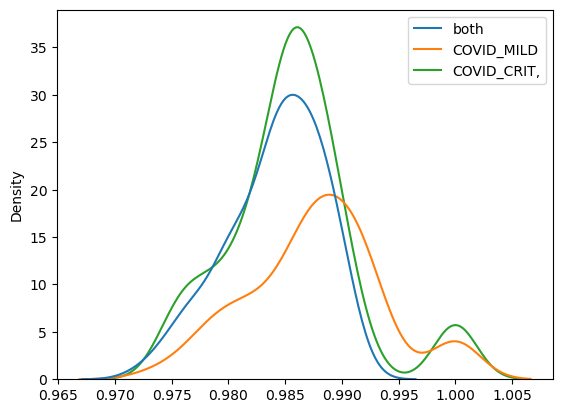

In [ ]:
sb.kdeplot(data = {"both":  COVID_MILD_COVID_CRIT, "COVID_MILD": COVID_MILD, "COVID_CRIT,": COVID_CRIT,})

<Axes: ylabel='Density'>

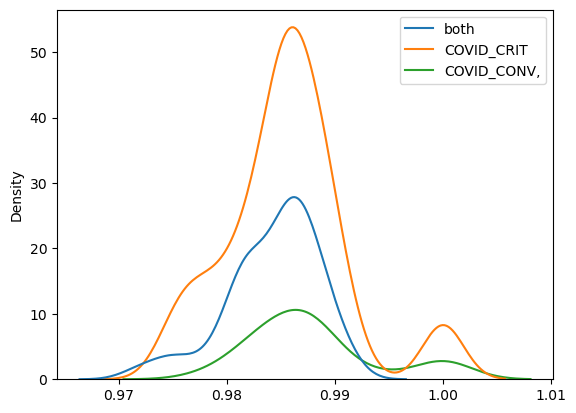

In [ ]:
sb.kdeplot(data = {"both":  COVID_CRIT_COVID_CONV, "COVID_CRIT": COVID_CRIT, "COVID_CONV,": COVID_CONV,})

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_7111/3467448788.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sb.kdeplot(data = {"both":  HV_COVID_HCW, "HV": HV, "COVID_HCW": COVID_HCW})


<Axes: ylabel='Density'>

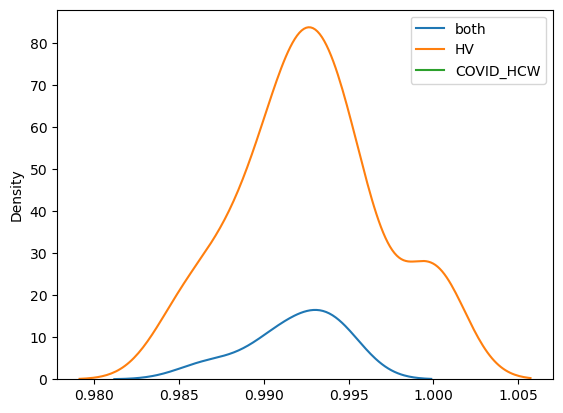

In [ ]:
sb.kdeplot(data = {"both":  HV_COVID_HCW, "HV": HV, "COVID_HCW": COVID_HCW})

<Axes: ylabel='Density'>

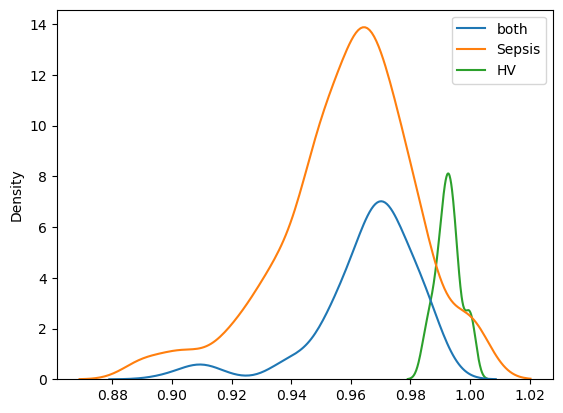

In [ ]:
sb.kdeplot(data = {"both": Sepsis_HV, "Sepsis": Sepsis, "HV": HV})

### Luminex

#### Heatmaps

Text(0.5, 918.991452991453, 'Patients')

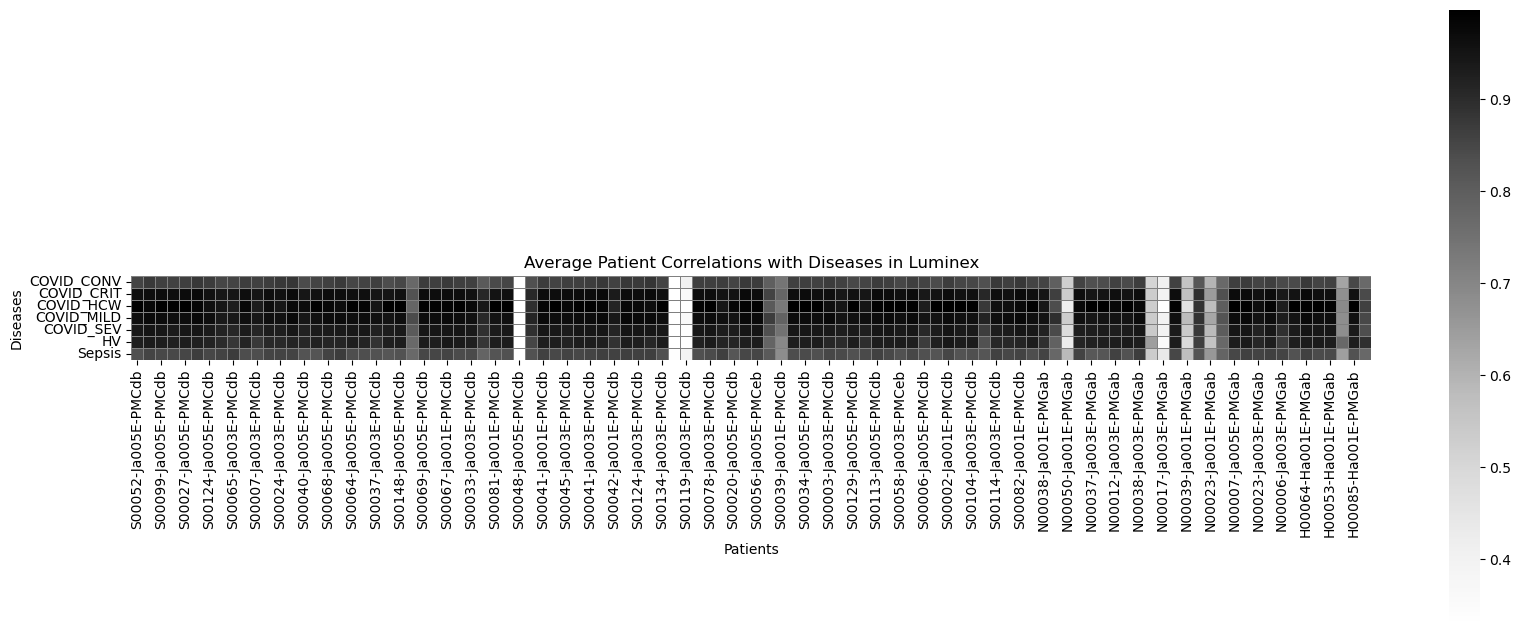

In [ ]:
fig,ax=plt.subplots(figsize=(20,20))
sb.heatmap(corr_p_d_luminex.transpose().groupby(corr_p_d_luminex.transpose().index).mean(), cmap ='Greys',  robust = True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.4}, square=True)
plt.title("Average Patient Correlations with Diseases in Luminex")
plt.ylabel("Diseases")
plt.xlabel("Patients")

Text(0.5, 248.22222222222211, 'Diseases')

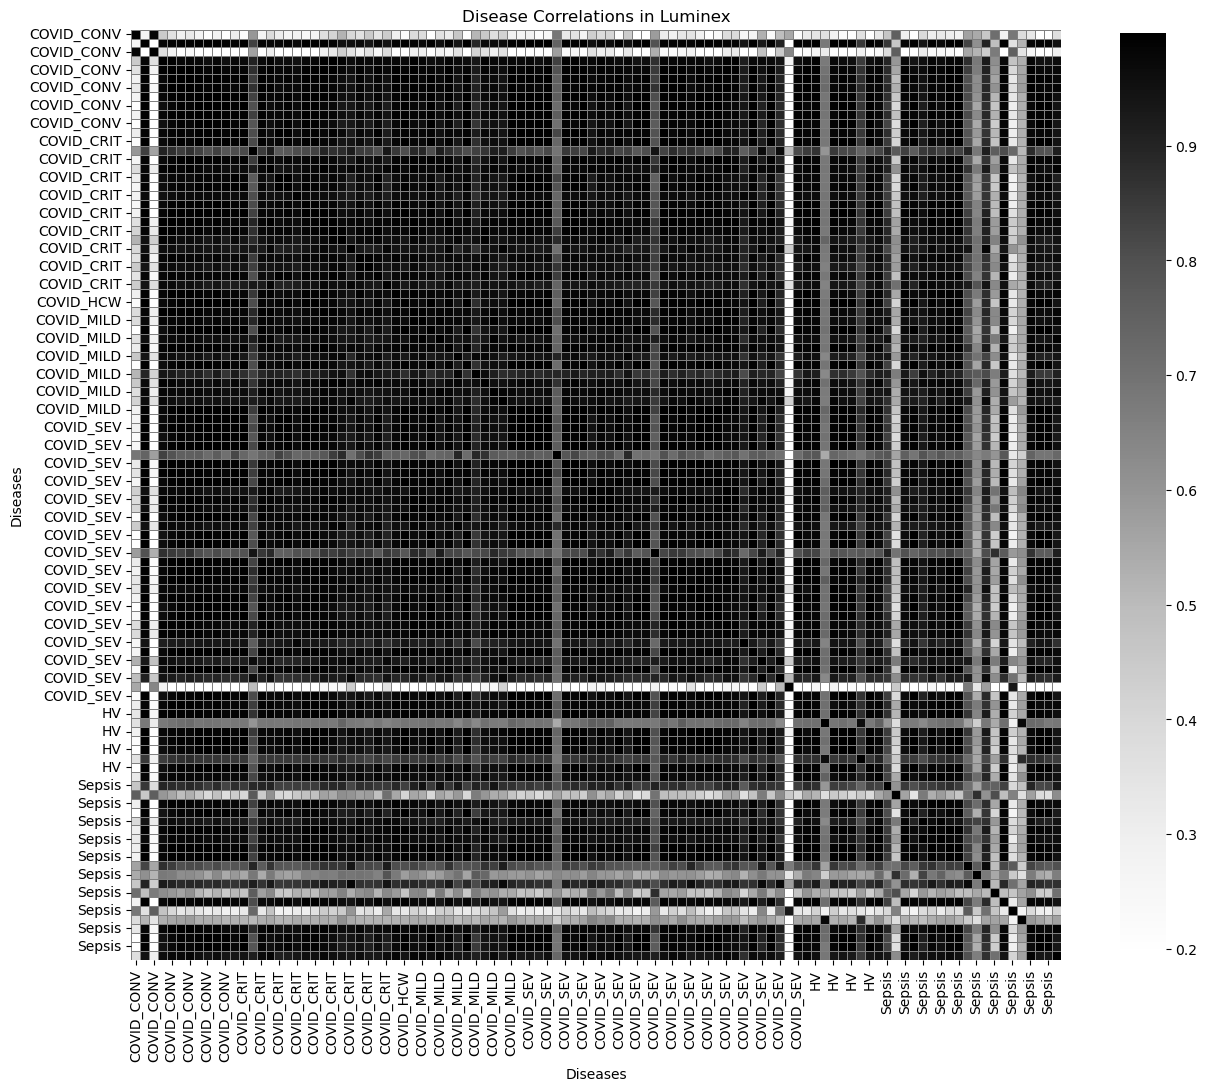

In [ ]:
fig,ax=plt.subplots(figsize=(15,15))
sb.heatmap(corr_d_luminex, cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.8})
plt.title("Disease Correlations in Luminex")
plt.ylabel("Diseases")
plt.xlabel("Diseases")

Text(0.5, 248.08159722222211, 'Patients')

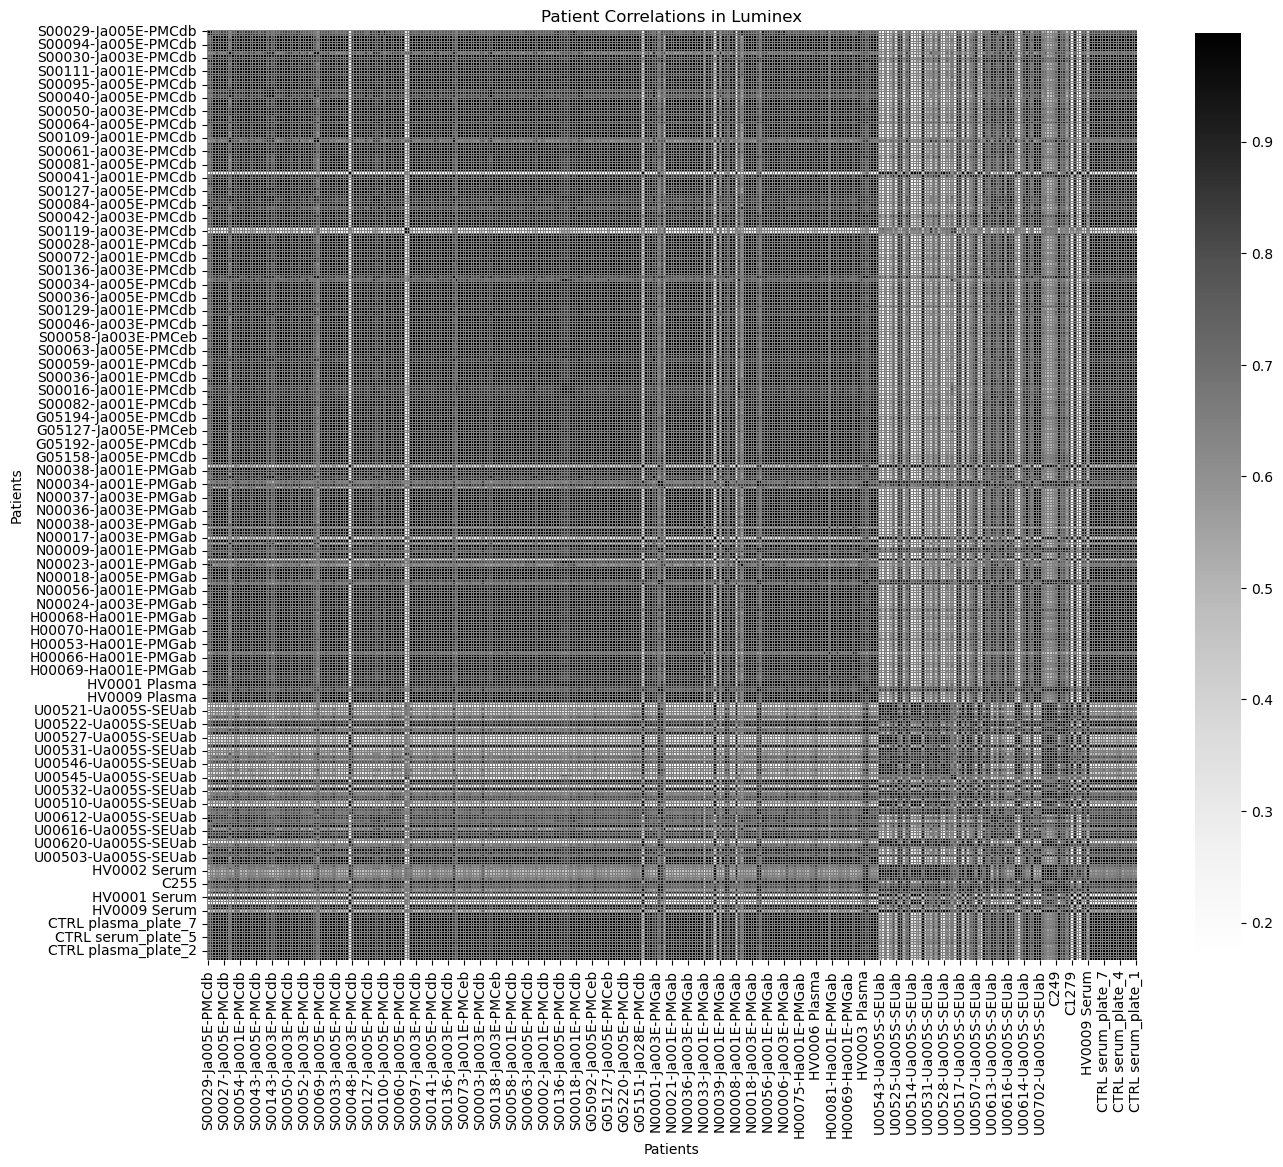

In [ ]:
fig,ax=plt.subplots(figsize=(15,15))
sb.heatmap(corr_p_luminex, cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.8})
plt.title("Patient Correlations in Luminex")
plt.ylabel("Patients")
plt.xlabel("Patients")

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.3, 'Simple Patient-Disease Correlations in Luminex with \n Two-Way Hierachical Clustering')

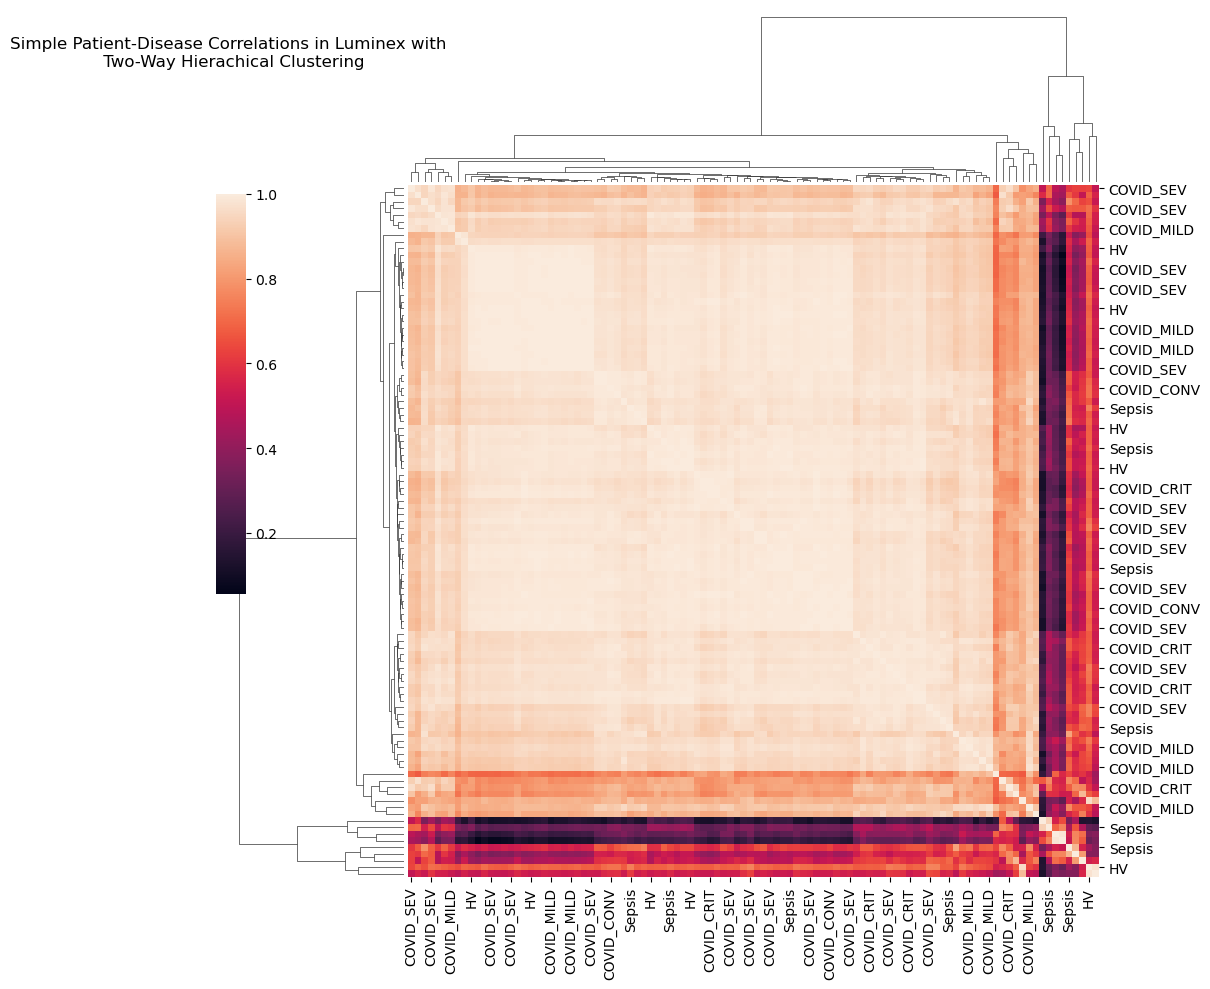

In [ ]:
sb.clustermap(corr_d_luminex, cbar_pos=(0, .4, .03, .4))
plt.title("Simple Patient-Disease Correlations in Luminex with \n Two-Way Hierachical Clustering", y = 1.3)

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 734.4444444444445, 'Patients')

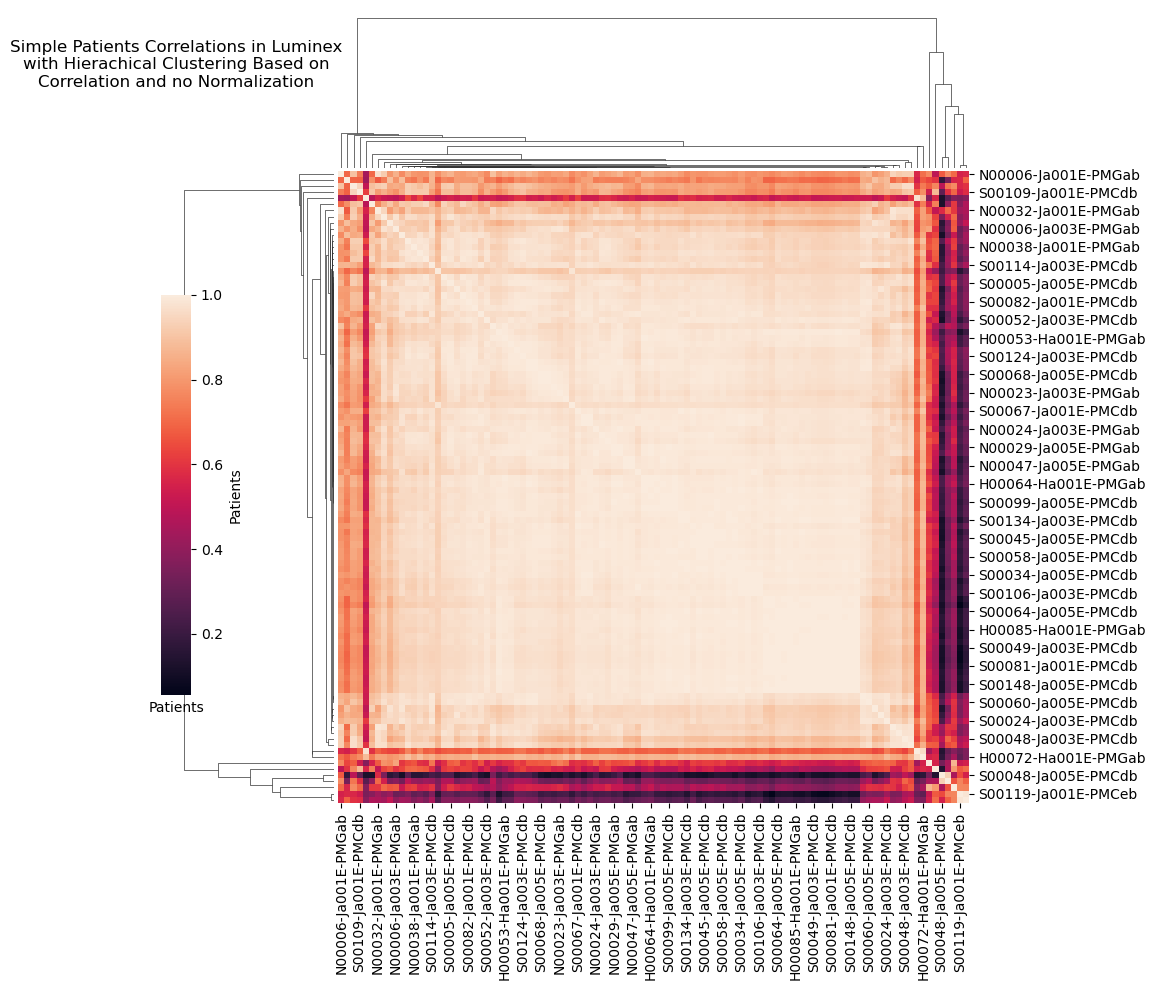

In [ ]:
sb.clustermap(corr_p_luminex, metric="correlation", method="single", cbar_pos=(0, .3, .03, .4))
plt.title("Simple Patients Correlations in Luminex" + "\n" + "with Hierachical Clustering Based on" + "\n" + "Correlation and no Normalization", y = 1.5)
plt.ylabel("Patients")
plt.xlabel("Patients")

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 734.4444444444445, 'Patients')

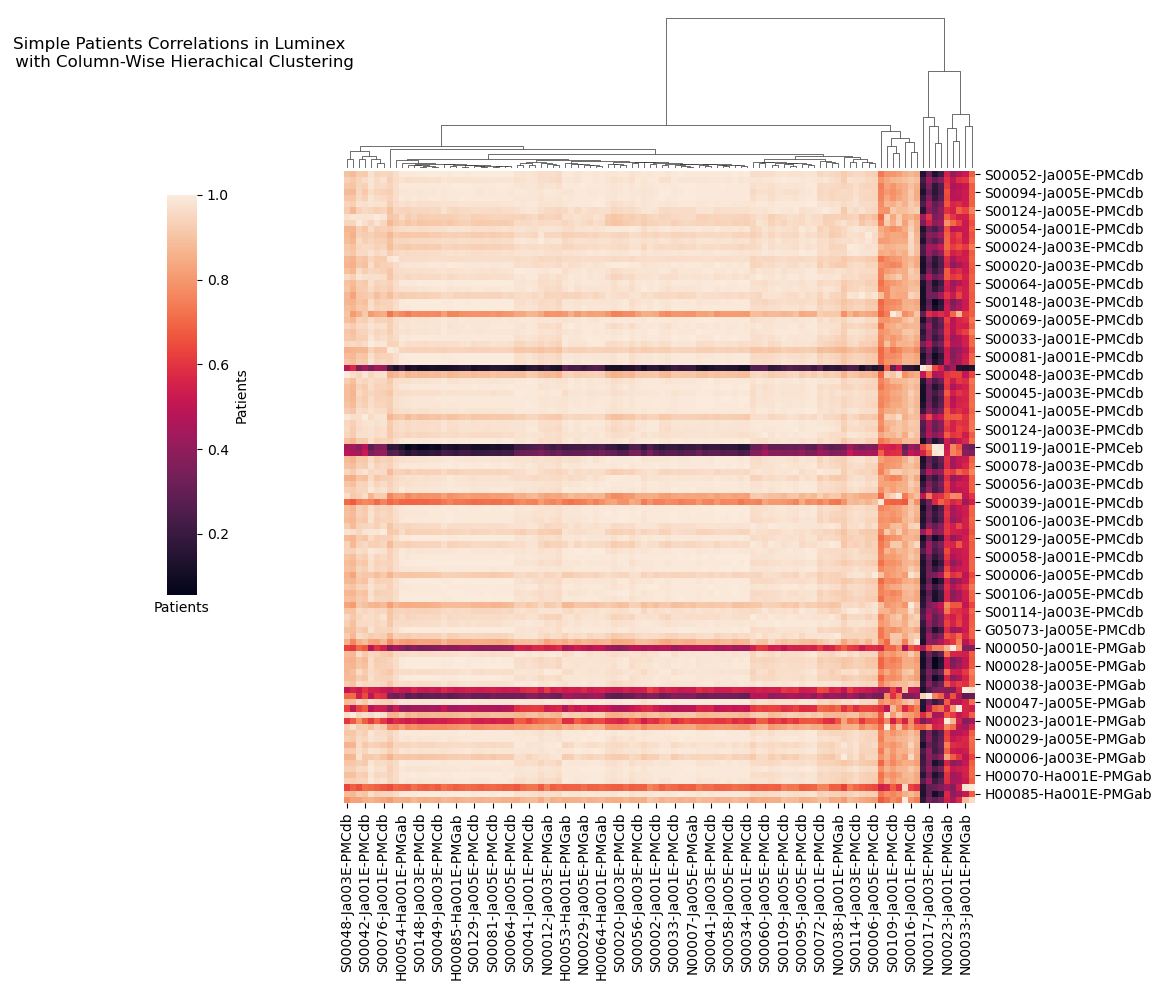

In [ ]:
sb.clustermap(corr_p_luminex, cbar_pos=(0, .4, .03, .4), row_cluster=False,)
plt.title("Simple Patients Correlations in Luminex \n with Column-Wise Hierachical Clustering" , y = 1.3)
plt.ylabel("Patients")
plt.xlabel("Patients")

### CyTOF

#### Heatmaps

In [ ]:
diseases = list(cytof_disease_clusters_corr[list(cytof_disease_clusters_corr.keys())[0]]["all"].index.unique())
for i in range(1, len(list(cytof_disease_clusters_corr.keys()))):
    key = list(cytof_disease_clusters_corr.keys())[i]
    diseases = diseases + list((cytof_disease_clusters_corr[key]["all"].index.unique()))
diseases = list(set(diseases))

disease_pairs = list(cytof_disease_clusters_corr[list(cytof_disease_clusters_corr.keys())[0]]["inter_diseases"].keys())
for i in range(1, len(list(cytof_disease_clusters_corr.keys()))):
    key = list(cytof_disease_clusters_corr.keys())[i]
    disease_pairs = disease_pairs + list((cytof_disease_clusters_corr[key]["inter_diseases"].keys()))
disease_pairs = list(set(disease_pairs))

Text(0.5, 92.58888888888886, 'Cell Types')

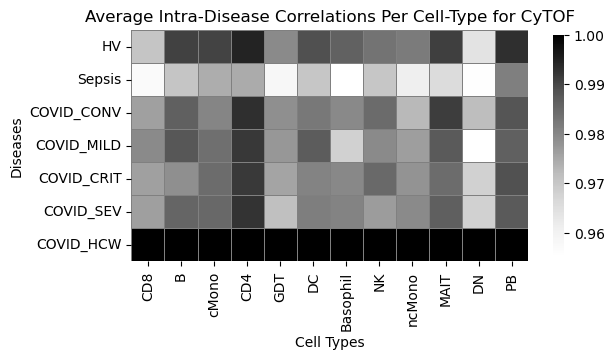

In [ ]:
# All Cell Types and Diseases: Average Correlation between Patients of the Same Disease
cell_type_intra_disease_avg = {ct:[0] * len(diseases) for ct in cytof_disease_clusters_corr.keys() }

for ct in cytof_disease_clusters_corr.keys():
    for i, disease in enumerate(diseases):
        cell_type_intra_disease_avg[ct][i] = cytof_disease_clusters_corr[ct]["intra_diseases"][disease].mean().mean()
        
df = pd.DataFrame(data =cell_type_intra_disease_avg, index = diseases)

sb.heatmap(df, cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.6})
plt.title("Average Intra-Disease Correlations Per Cell-Type for CyTOF")

plt.ylabel("Diseases")
plt.xlabel("Cell Types")


Text(0.5, 1.3, 'Simple Disease-Cell-Type Correlations \n in CyTOF with \n Two-Way Hierachical Clustering')

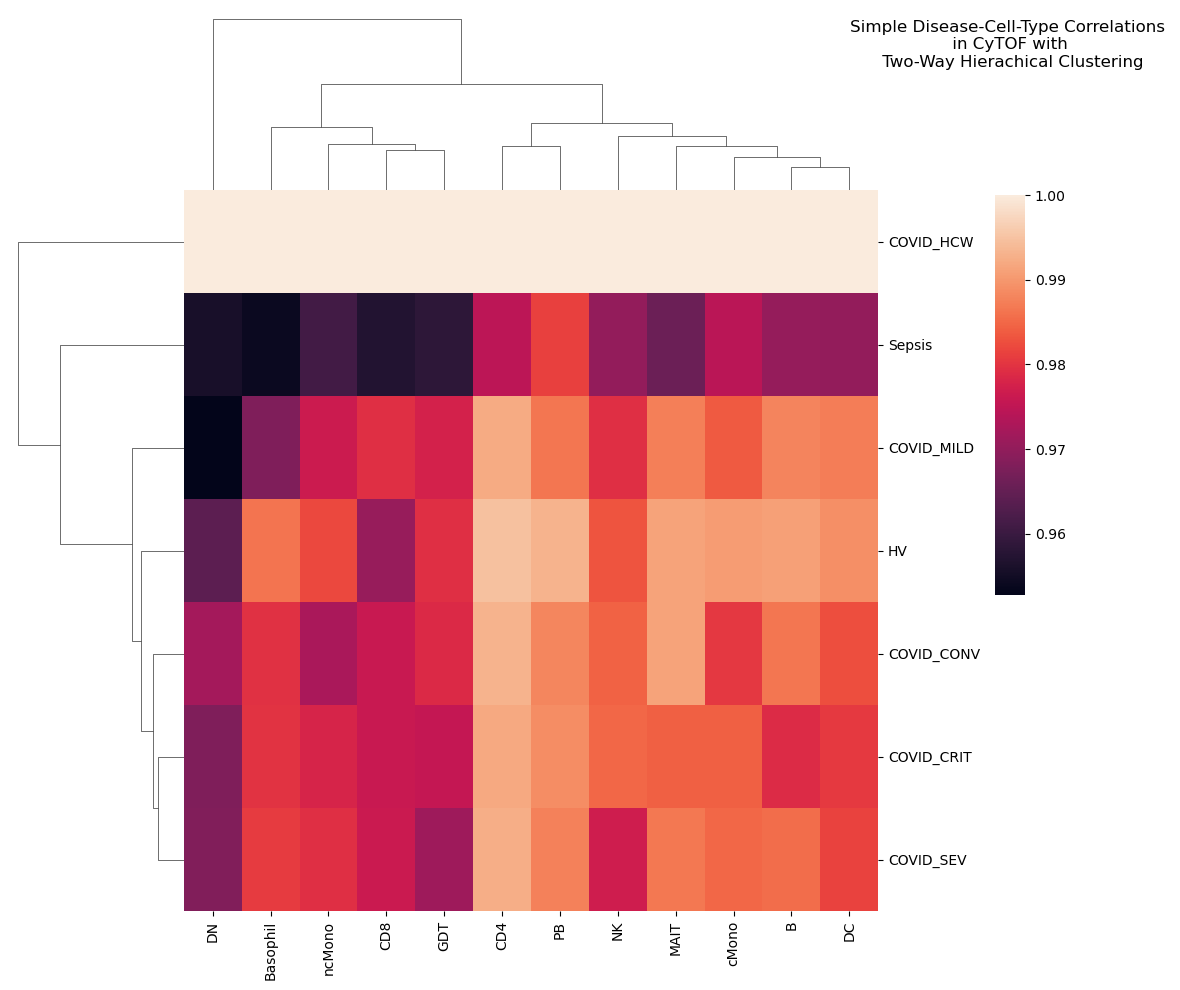

In [ ]:
sb.clustermap(df, cbar_pos=(1, .4, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations \n in CyTOF with \n Two-Way Hierachical Clustering", y = 1.3)

Text(0.5, 23.52222222222222, 'Cell Types')

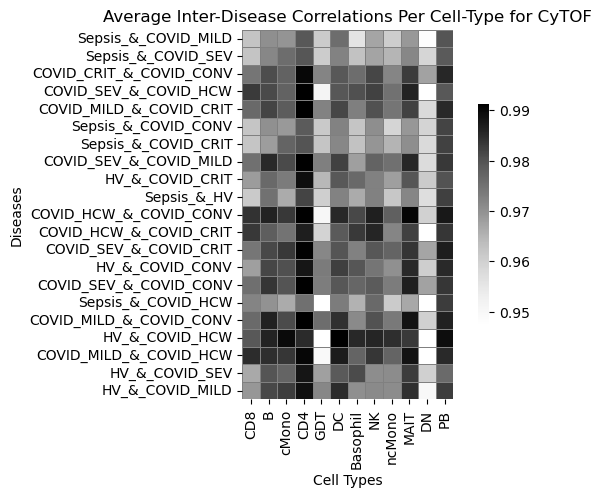

In [ ]:
# Avergae Correlation of the Patients of two different diseases
cell_type_inter_disease_avg = {ct:[0] * len(disease_pairs) for ct in cytof_disease_clusters_corr.keys() }

for ct in cytof_disease_clusters_corr.keys():
    for i, pair in enumerate(disease_pairs):
        cell_type_inter_disease_avg[ct][i] = cytof_disease_clusters_corr[ct]["inter_diseases"][pair].mean().mean()
        
df = pd.DataFrame(data =cell_type_inter_disease_avg, index = disease_pairs)

sb.heatmap(df, cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.6})
plt.title("Average Inter-Disease Correlations Per Cell-Type for CyTOF")
plt.ylabel("Diseases")
plt.xlabel("Cell Types")

Text(0.5, 1.5, 'Simple Disease-Cell-Type Correlations in CyTOF \n with Hierachical Clustering Based on \n Correlation and no Normalization')

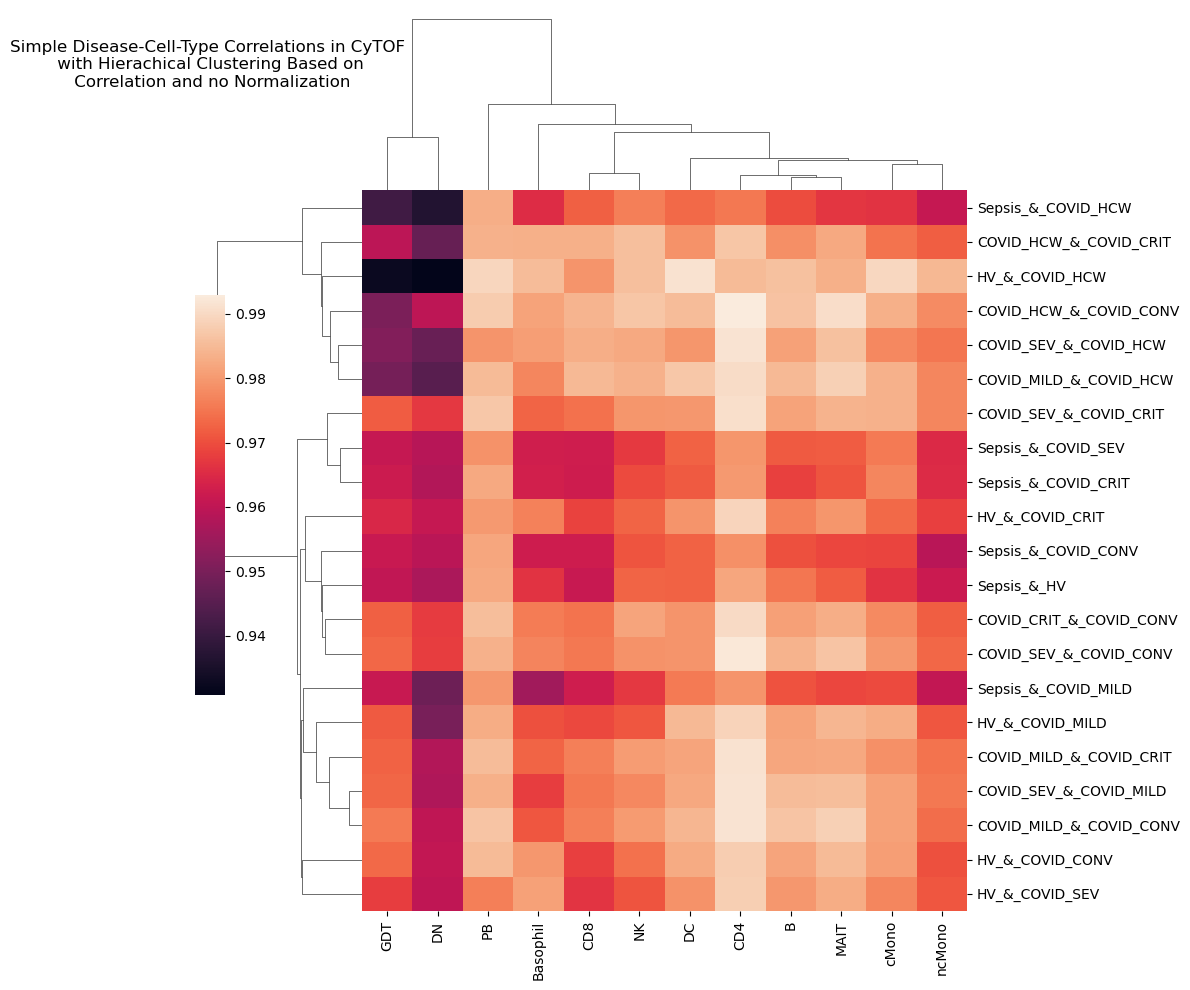

In [ ]:
sb.clustermap(df, metric="correlation", method="single", cbar_pos=(0, .3, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations in CyTOF \n with Hierachical Clustering Based on \n Correlation and no Normalization", y = 1.5)


Text(0.5, 1.3, 'Simple Disease-Cell-Type Correlations in CyTOF \n with Column-Wise Hierachical \n Clustering')

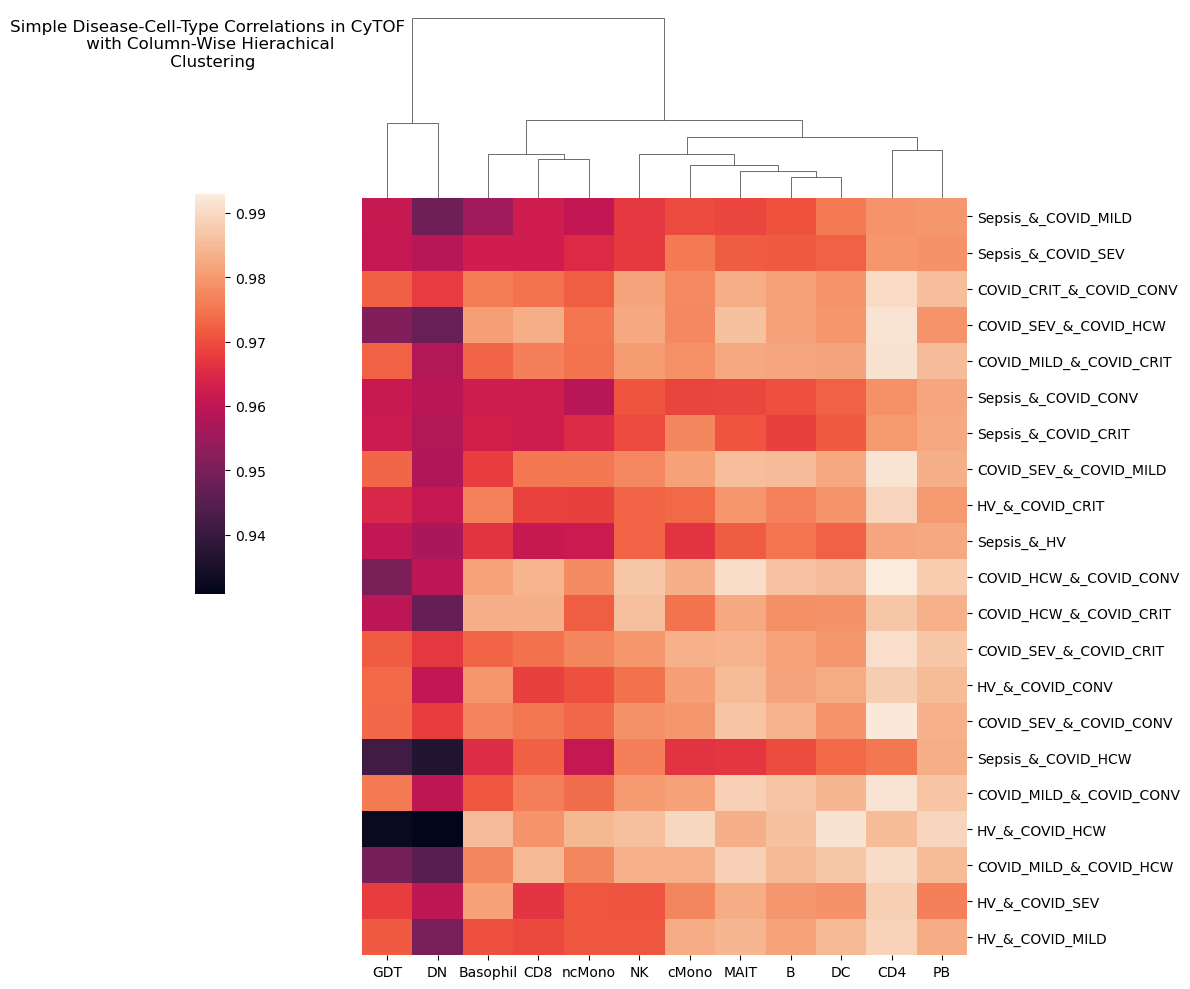

In [ ]:
sb.clustermap(df, cbar_pos=(0, .4, .03, .4), row_cluster=False,)
plt.title("Simple Disease-Cell-Type Correlations in CyTOF \n with Column-Wise Hierachical \n Clustering" , y = 1.3)


Text(0.5, 1.3, 'Simple Disease-Cell-Type Correlations \n in CyTOF with \n Two-Way Hierachical Clustering')

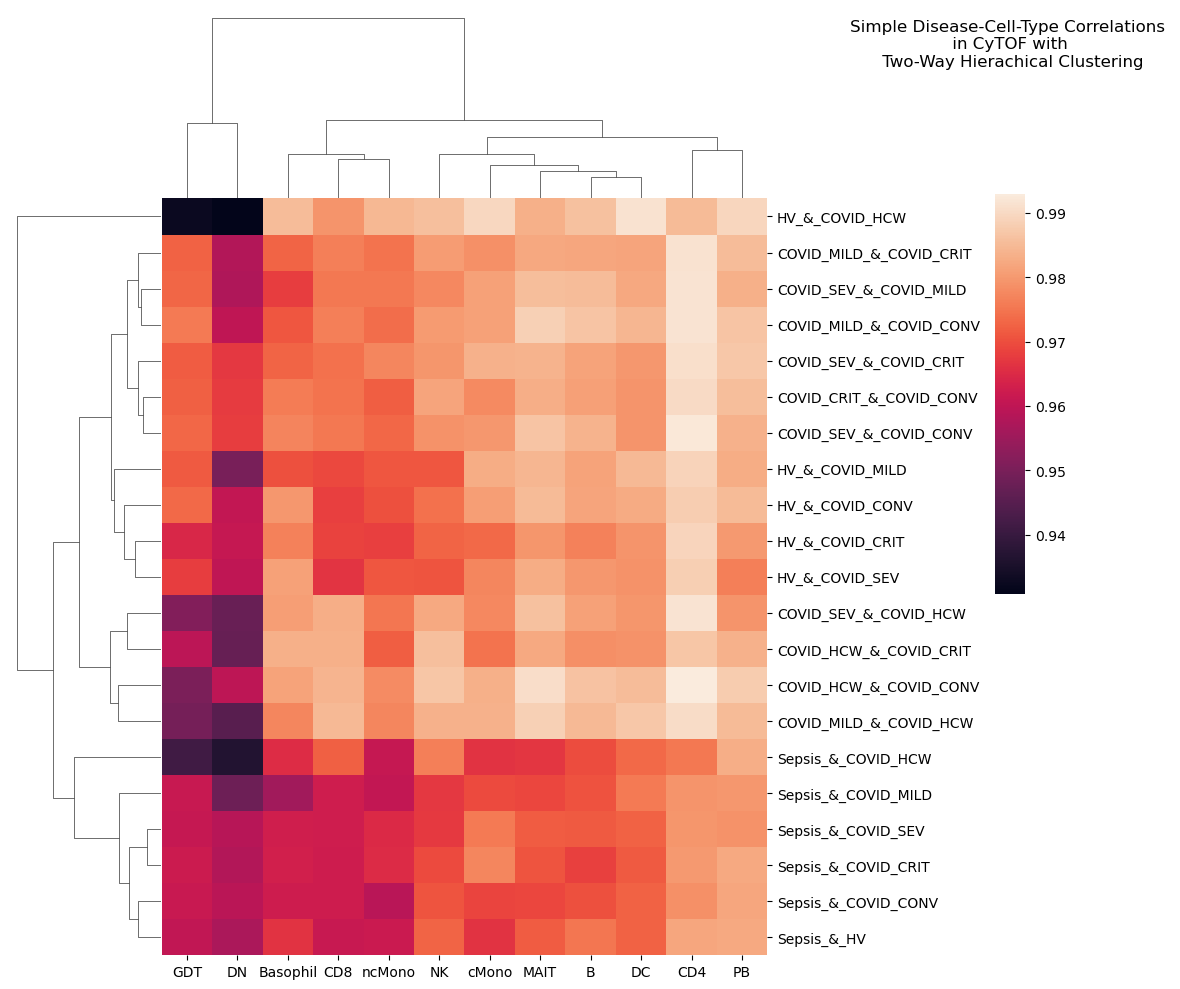

In [ ]:
sb.clustermap(df, cbar_pos=(1, .4, .03, .4))
plt.title("Simple Disease-Cell-Type Correlations \n in CyTOF with \n Two-Way Hierachical Clustering", y = 1.3)

Text(0.5, 1157.9907407407406, 'Patients')

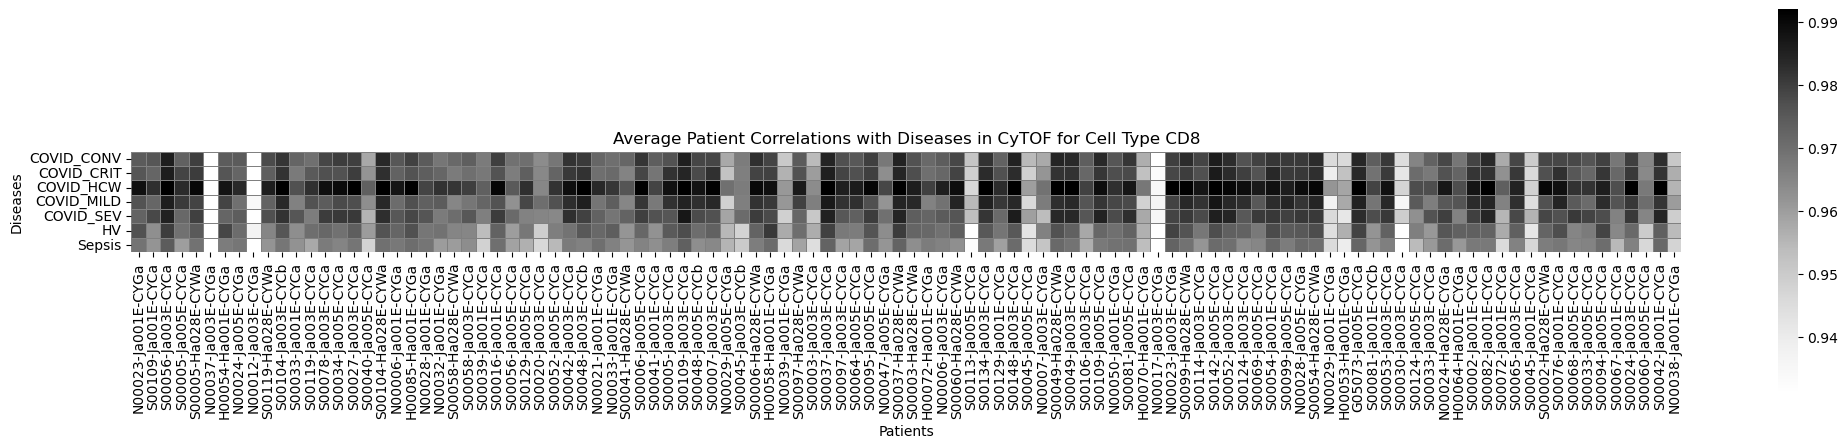

In [ ]:
fig,ax=plt.subplots(figsize=(25,25))
sb.heatmap(corr_p_d_cytof["CD8"].transpose().groupby(corr_p_d_cytof["CD8"].transpose().index).mean(), cmap ='Greys', robust = True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.2},square=True )
plt.title("Average Patient Correlations with Diseases in CyTOF for Cell Type CD8")
plt.ylabel("Diseases")
plt.xlabel("Patients")

Text(0.5, 1.0, 'Cell Type CD8 Disease Correlations in CyTOF')

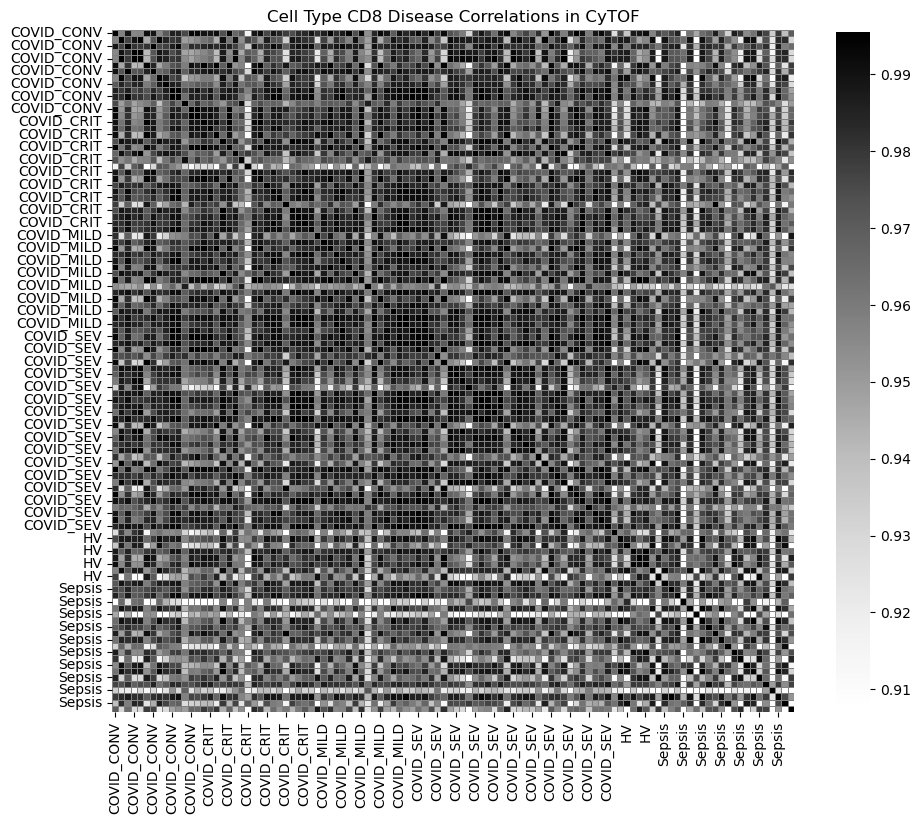

In [ ]:
fig,ax=plt.subplots(figsize=(11,11))
sb.heatmap(cytof_disease_clusters_corr["CD8"]["all"], cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.8})
plt.title("Cell Type CD8 Disease Correlations in CyTOF")

Text(0.5, 1.0, 'Cell Type CD8 Patient Correlations in CyTOF')

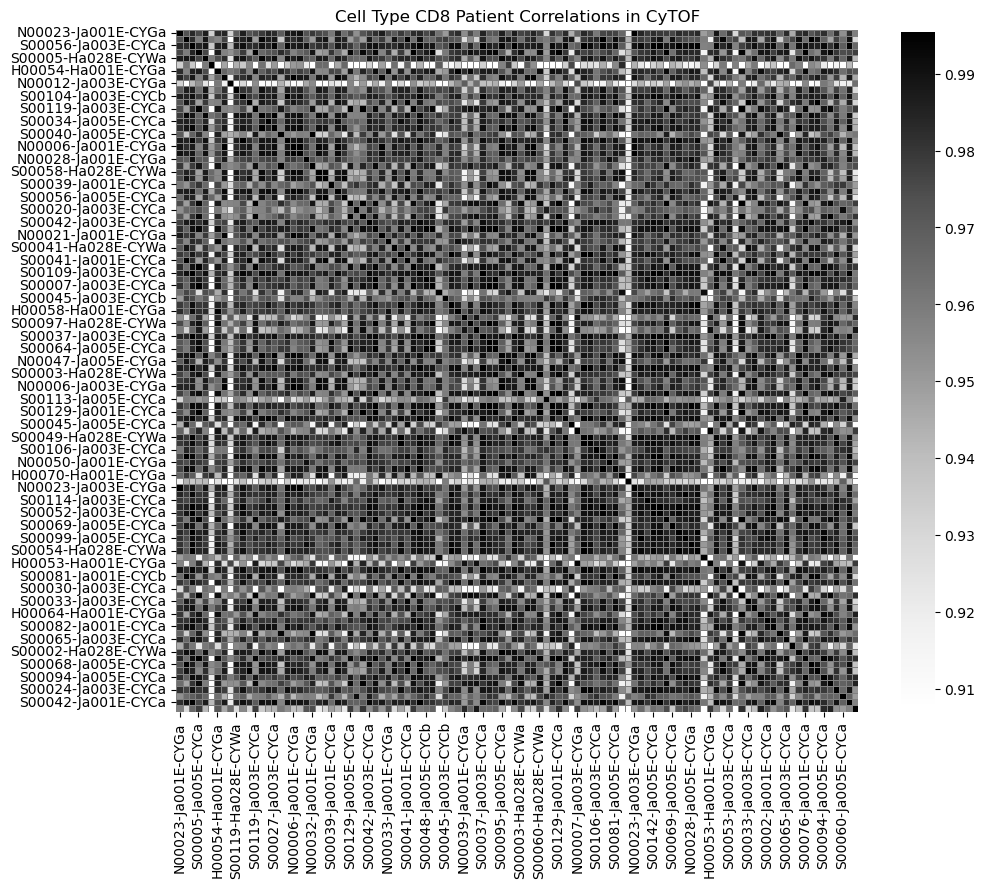

In [ ]:
fig,ax=plt.subplots(figsize=(11,11))
sb.heatmap(corr_p_cytof["CD8"], cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.8})
plt.title("Cell Type CD8 Patient Correlations in CyTOF")

##### cMono

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.5, 'Simple Disease Correlations in CyTOF \n with Hierachical Clustering Based on \n Correlation and no Normalization for cMono')

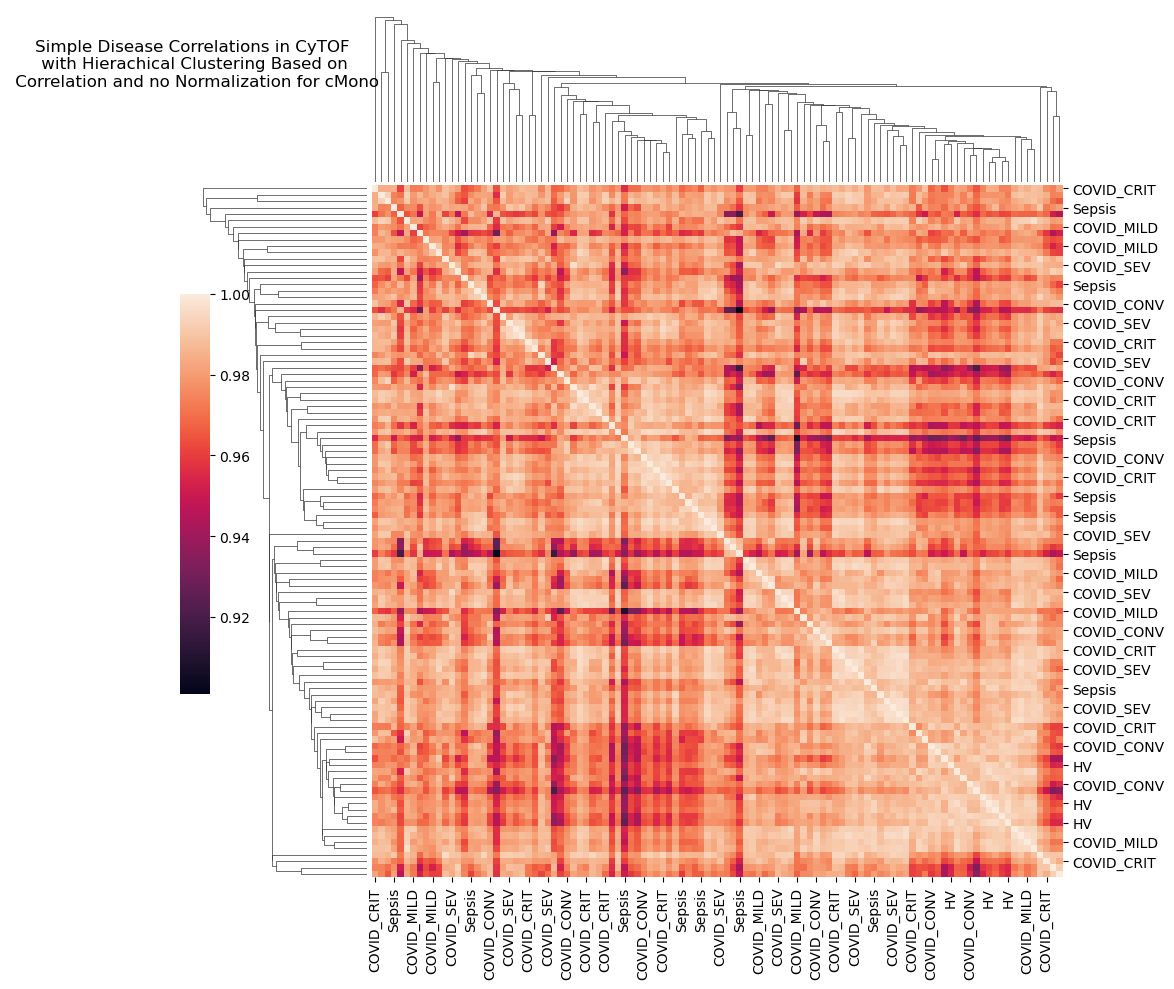

In [ ]:
sb.clustermap(cytof_disease_clusters_corr["cMono"]["all"], metric="correlation", method="single", cbar_pos=(0, .3, .03, .4))
plt.title("Simple Disease Correlations in CyTOF \n with Hierachical Clustering Based on \n Correlation and no Normalization for cMono", y = 1.5)

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.3, 'Simple Disease Correlations in CyTOF \n with Column-Wise Hierachical \n Clustering for cMono')

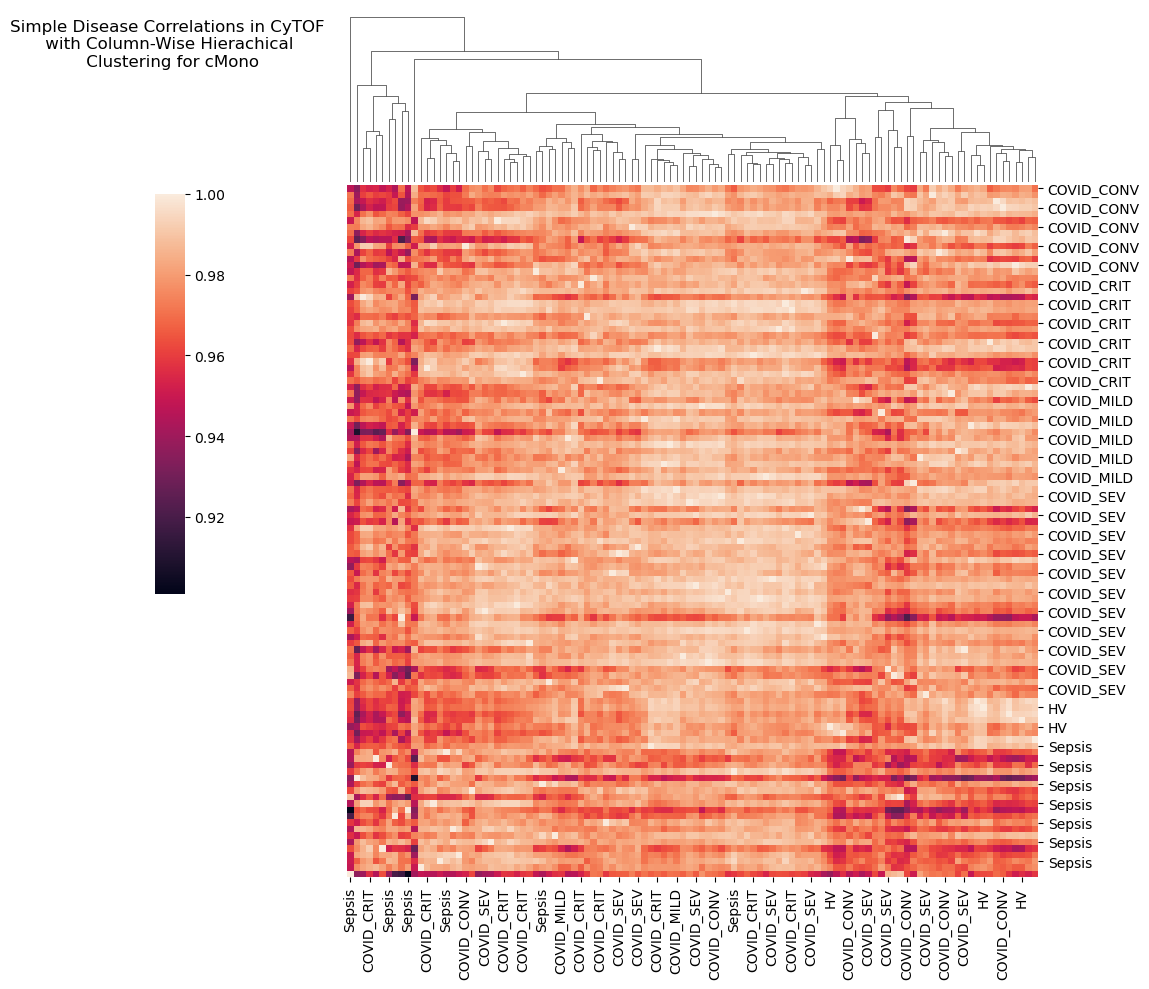

In [ ]:
sb.clustermap(cytof_disease_clusters_corr["cMono"]["all"], cbar_pos=(0, .4, .03, .4), row_cluster=False,)
plt.title("Simple Disease Correlations in CyTOF \n with Column-Wise Hierachical \n Clustering for cMono" , y = 1.3)

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 1.3, 'Simple Disease Correlations \n in CyTOF with \n Two-Way Hierachical Clustering for cMono')

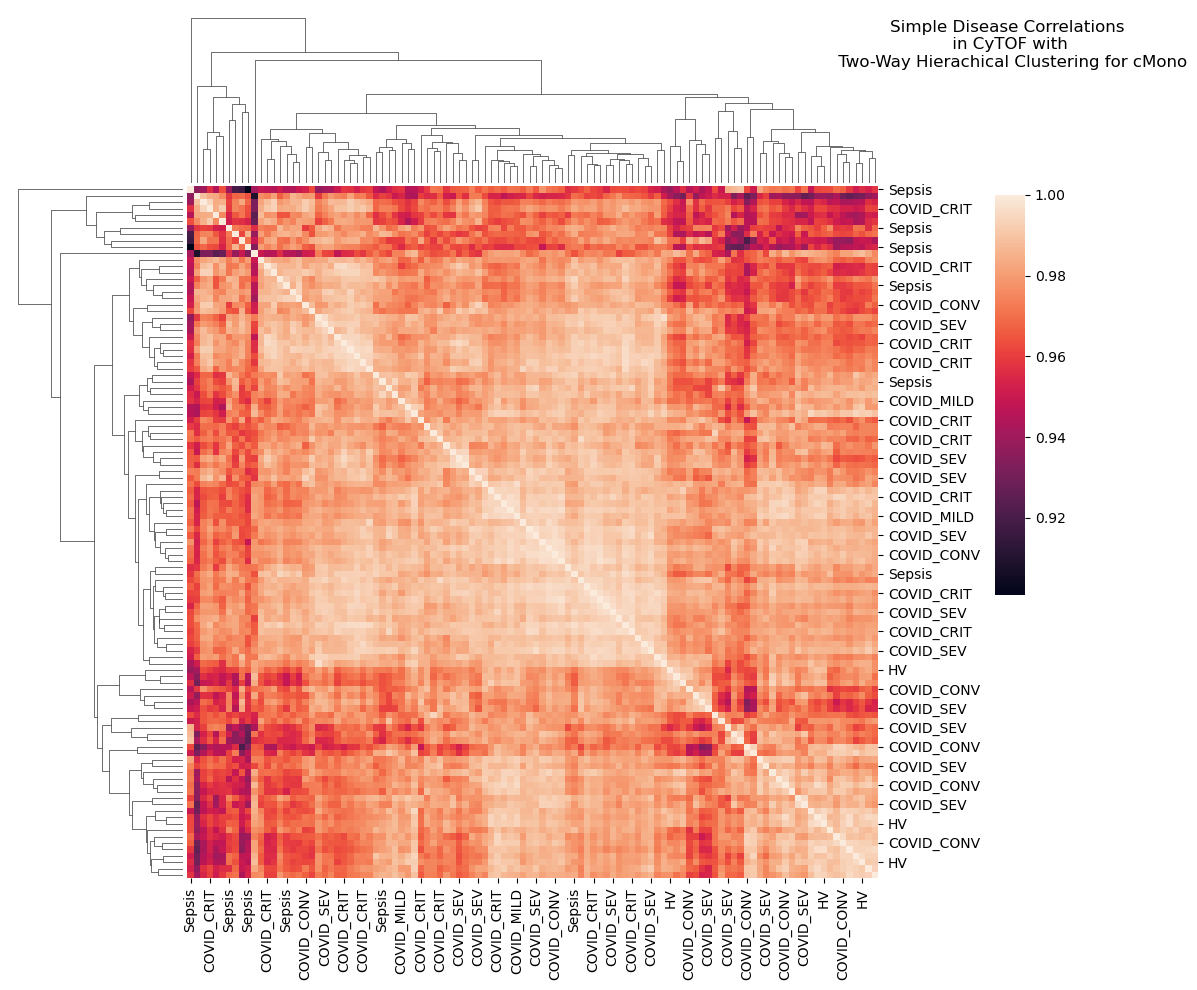

In [ ]:
sb.clustermap(cytof_disease_clusters_corr["cMono"]["all"], cbar_pos=(1, .4, .03, .4))
plt.title("Simple Disease Correlations \n in CyTOF with \n Two-Way Hierachical Clustering for cMono", y = 1.3)

Text(0.5, 1157.9907407407406, 'Patients')

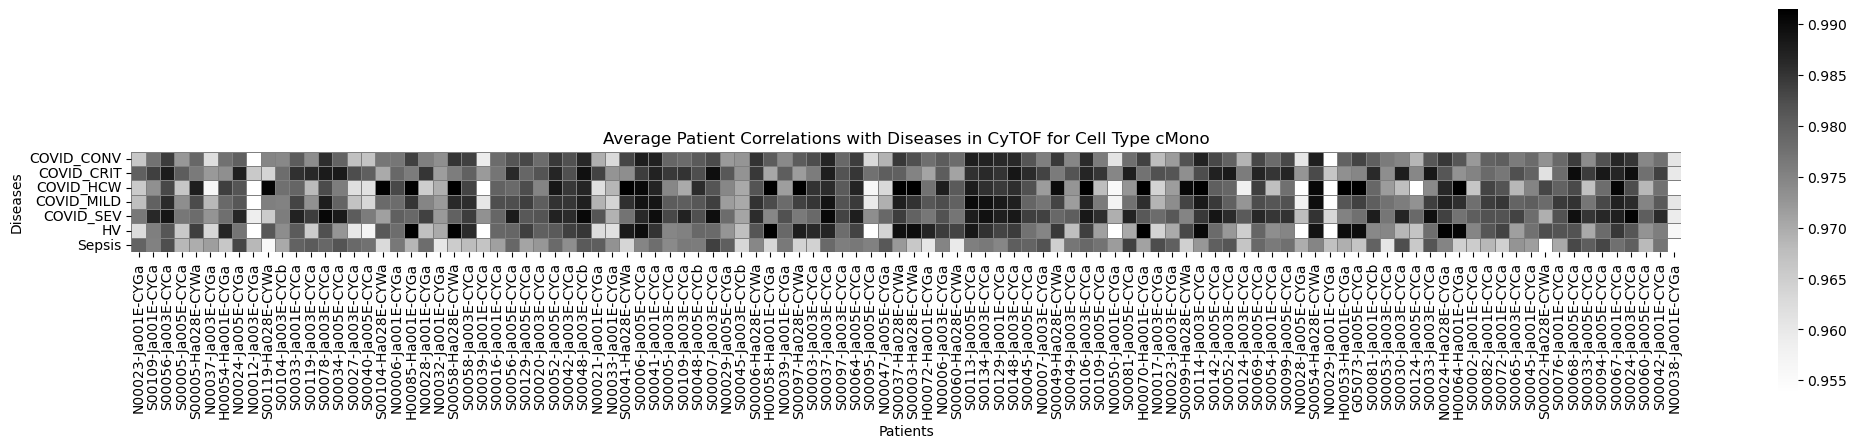

In [ ]:
fig,ax=plt.subplots(figsize=(25,25))
sb.heatmap(corr_p_d_cytof["cMono"].transpose().groupby(corr_p_d_cytof["cMono"].transpose().index).mean(), cmap ='Greys', robust = True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.2}, square=True)
plt.title("Average Patient Correlations with Diseases in CyTOF for Cell Type cMono")
plt.ylabel("Diseases")
plt.xlabel("Patients")

Text(0.5, 1.0, 'Cell Type cMono Disease Correlations in CyTOF')

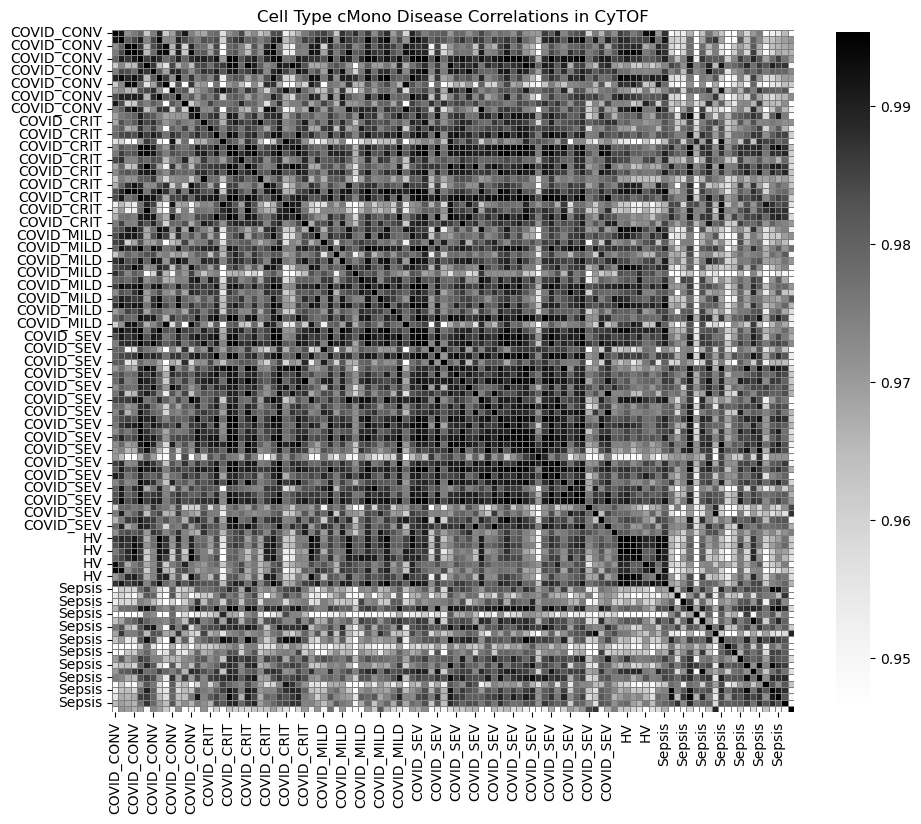

In [ ]:
fig,ax=plt.subplots(figsize=(11,11))
sb.heatmap(cytof_disease_clusters_corr["cMono"]["all"], cmap ='Greys',  robust = True, square= True, linewidth=.5, linecolor = "grey" , ax = ax, cbar_kws={"shrink": 0.8})
plt.title("Cell Type cMono Disease Correlations in CyTOF")